# Importing packages

In [1]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/cardiac-amyloidosis/040_Mistic_2025/SVMsClinicalSplit


In [2]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [4]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "SVM_linear_" #what data did you put in
fileName_common = "EchoAdj_clinSplit_red025_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250522_v1" #date and versioning

saving_dirrectory = os.path.join("012 Processed Data","019_clinicalSplit")
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "SVM_linear_EchoAdj_clinSplit_red025_", 
                                     folderName_common= "250522_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = os.path.join("012 Processed Data","019_clinicalSplit")
figFolder = makingFolder 


In [5]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [6]:
#parameters of SVM 
red_factor = 0.25

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

# rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]
rank_weights = [0, 0.2, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]

In [7]:
# test set patients selected 1/5 from the sorted mean KPS scores for the CA+ and CA- subgroups of all patients
testSetPatients = ['T-01', 'B-02', 'I-01', 'Y-02', 'F-03', 'B-03', 'F-01', 'G-03', 'Q-01', 'C-01']
trainSetPatients = ['C-03', 'E-01', 'E-02', 'G-02', 'I-03', 'J-02', 'K-02', 'M-02', 'N-03', 'O-03', 'Q-02', 'Q-03', 'V-02', 'W-01', 'X-01', 'X-02',
                    'A-02', 'C-02', 'E-03', 'H-01', 'H-02', 'M-01', 'N-01', 'N-02', 'P-01', 'P-02', 'R-01', 'R-03', 'S-02', 'T-02', 'V-01', 'W-02', 'Y-01', 'Z-01']

# importing our data

In [8]:
dataFileName = "DF_SVM_noNotes_EchoAdj__20250502_v1.xlsx"

In [9]:
# "C:\Users\maega\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\015_Mistic2025\DFsForSVM_noNotes__20250502_v1\DF_SVM_noNotes_EchoAdj__20250502_v1.xlsx"

In [10]:
# Import dataset
dataTable = pd.read_excel(dataFileName, sheet_name = "knownPts", header = 0) #the dataset we are using

dataTable.index = dataTable['DeID']

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'CA_status_yes']

#columns to use for the y data 
y_column_Classification = 'CA_status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

sex_female  dx_mgus  dx_mm  HematologicTx  RadiationTx  OtherTx  \
DeID                                                                    
B-02           0        1      0              0            0        0   
C-03           1        0      1              0            0        0   
E-01           0        1      0              0            0        0   
E-02           0        1      0              0            0        0   
F-03           0        0      1              1            0        0   
G-02           1        0      1              0            0        0   
I-01           1        0      1              0            0        0   
I-03           0        1      0              0            0        0   
J-02           1        0      1              0            0        0   
K-02           1        0      1              0            0        0   
M-02           0        1      0              0            0        0   
N-03           0        0      1              0            0        0   
O-03           1        0      1              0            0        0   
Q-02           0        1      0              0            0        0   
Q-03           1        0      1              0            0        0   
T-01           0        0      0              0            0        0   
V-02           0        0      1              0            0        0   
W-01           0        0      1              0            0        0   
X-01           0        1      0              0            0        0   
X-02           0        1      0              0            0        0   
Y-02           1        1      0              0            0        0   
A-02           1        1      0              0            0        0   
B-03           0        0      1              0            0        0   
C-01           1        0      0              0            0        0   
C-02           0        0      1              1            0        0   
E-03           0        1      0              0            0        0   
F-01           0        0      1              1            0        0   
G-03           1        1      0              0            0        0   
H-01           0        1      0              0            0        0   
H-02           0        0      1              1            1        0   
M-01           0        0      1              0            0        0   
N-01           0        0      0              0            0        2   
N-02           0        0      1              0            0        0   
P-01           0        0      1              0            0        0   
P-02           1        0      1              1            0        0   
Q-01           1        1      0              0            0        0   
R-01           0        0      1              1            0        0   
R-03           1        1      0              0            0        0   
S-02           1        0      1              0            0        0   
T-02           0        0      1              1            0        0   
V-01           1        0      1              1            0        0   
W-02           0        1      0              0            0        0   
Y-01           0        0      1              0            0        0   
Z-01           1        0      0              0            0        0   

      ChemoTx_True  HematologicTx_True  RadiationTx_True  ImmunoTx_True  \
DeID                                                                      
B-02             0                   0                 0              0   
C-03             1                   0                 0              0   
E-01             0                   0                 0              0   
E-02             0                   0                 0              0   
F-03             1                   1                 0              0   
G-02             0                   0                 0              0   
I-01             1                   0         

# Setting up classifier

## Scaling data and defining test set

In [11]:
scaler = StandardScaler().set_output(transform = 'pandas')
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
#                                                     stratify = y_all, 
#                                                     random_state= randomSeed, 
#                                                     test_size= test_size_numb)

X_train = X_all.loc[trainSetPatients]
y_train = y_all.loc[trainSetPatients]
X_test = X_all.loc[testSetPatients]
y_test = y_all.loc[testSetPatients]

# max(X_all[:,0])
X_all.max().max()

6.557438524302

In [12]:
outputToExcel(df_data=dataTable.loc[trainSetPatients], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "train_data")
outputToExcel(df_data=dataTable.loc[testSetPatients], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "test_data")

## define cross validation

In [13]:
#convert everything to numpy arrays to get the rest to run 
X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()
X_all = X_all.to_numpy()

In [14]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [15]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.5904761904761905,
 'auc': 0.7333333333333335,
 'score': 0.661904761904762,
 'C': 0.0078125}

In [16]:
test_y_predict = test.predict(X_test)
decision_values = test.decision_function(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_y_predict).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 
                       'false neg': fn, 'true pos': tp,
                       'precision or PPV': precision, 
                       'recall or TPR': recall, 'specificity or TNR': specificity}
dict_temp_blindpred


{'f1': 0.4000000000000001,
 'auc': 0.48,
 'true neg': 2,
 'false pos': 3,
 'false neg': 3,
 'true pos': 2,
 'precision or PPV': 0.4,
 'recall or TPR': 0.4,
 'specificity or TNR': 0.4}

## testing other models

In [17]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [18]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print( "ROC: ", roc_auc_score(y_test, y_pred))

importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(ax=ax)
# fig.tight_layout()

F1:  0.0
ROC:  0.4


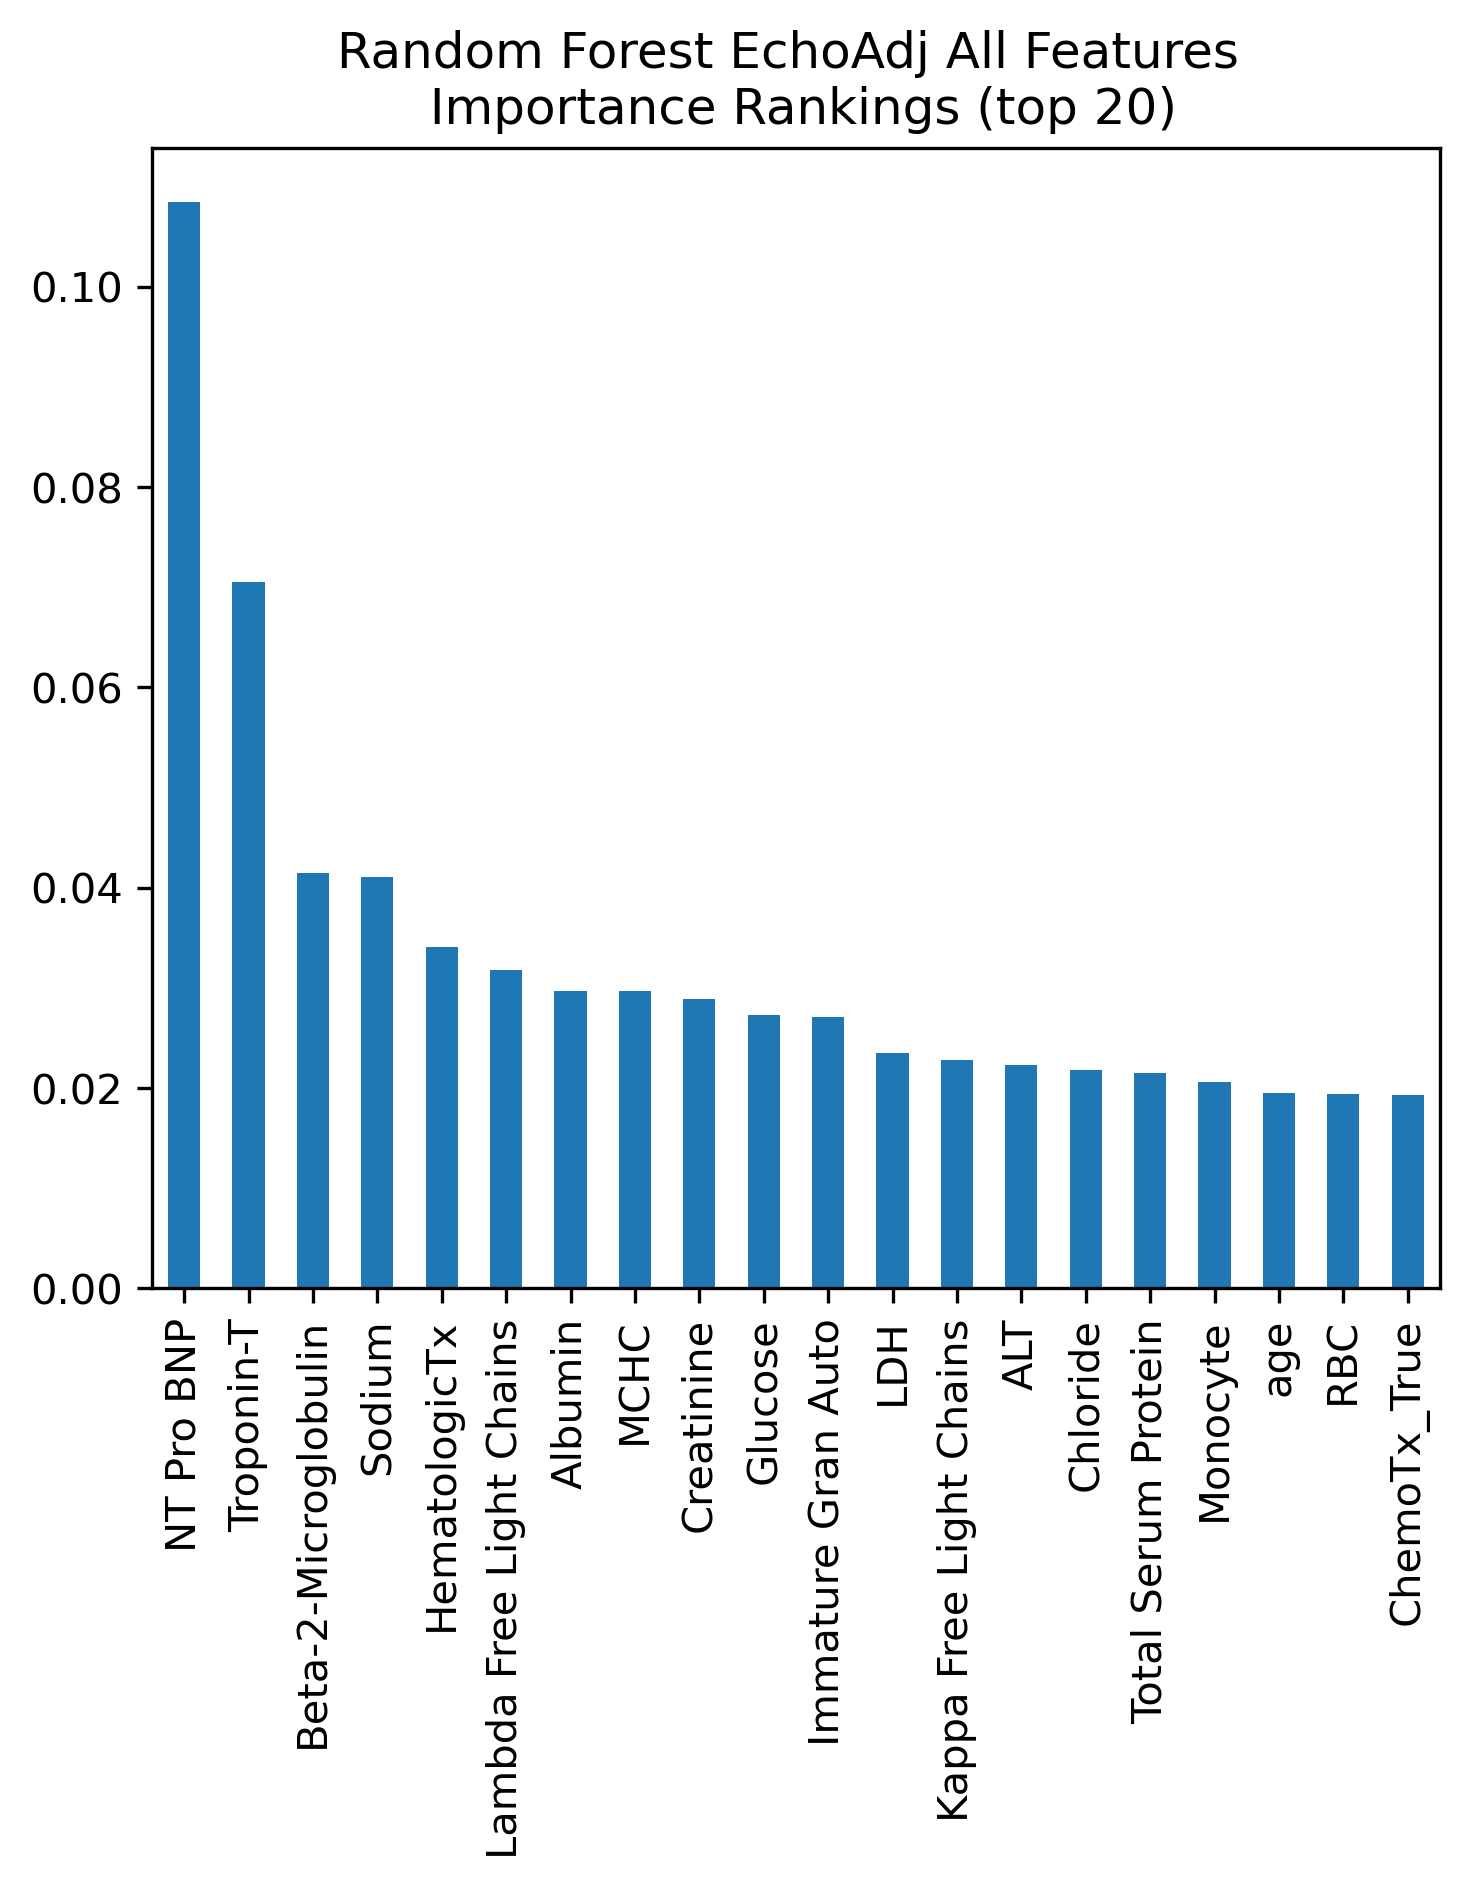

In [19]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = forest_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest EchoAdj All Features \n Importance Rankings (top 20)")

# Show the plot
plt.show()

In [20]:
what_train = pd.DataFrame(X_train, columns = X.columns) 
what_test = pd.DataFrame(X_test, columns = X.columns) 

In [21]:
what_train

sex_female   dx_mgus     dx_mm       age  survival(mo)   ChemoTx  \
0     1.260252 -0.755929  0.912871 -0.389485     -0.473373  0.563970   
1    -0.793492  1.322876 -1.095445 -1.275899      1.658145 -0.742065   
2    -0.793492  1.322876 -1.095445  0.102967     -0.337291 -0.742065   
3     1.260252 -0.755929  0.912871 -2.654766      0.036935 -0.742065   
4    -0.793492  1.322876 -1.095445  0.398439     -0.746846 -0.742065   
5     1.260252 -0.755929  0.912871  0.496929     -0.120083 -0.089048   
6     1.260252 -0.755929  0.912871  0.496929     -0.080829 -0.089048   
7    -0.793492  1.322876 -1.095445  0.693910     -0.167188 -0.742065   
8    -0.793492 -0.755929  0.912871  0.595420     -0.826664 -0.742065   
9     1.260252 -0.755929  0.912871  0.792401     -0.974522 -0.742065   
10   -0.793492  1.322876 -1.095445  0.595420      0.472660 -0.742065   
11    1.260252 -0.755929  0.912871 -2.162313     -1.004617 -0.742065   
12   -0.793492 -0.755929  0.912871  1.580324      0.822024 -0.089048   
13   -0.793492 -0.755929  0.912871 -0.586466      0.507989  1.216987   
14   -0.793492  1.322876 -1.095445  1.678815     -0.932651 -0.742065   
15   -0.793492  1.322876 -1.095445  0.004477      0.360130 -0.742065   
16    1.260252  1.322876 -1.095445  1.087872     -0.855450 -0.742065   
17   -0.793492 -0.755929  0.912871 -0.389485      0.154698  0.563970   
18   -0.793492  1.322876 -1.095445 -0.094014     -0.596371 -0.742065   
19   -0.793492  1.322876 -1.095445 -0.684956      0.706878 -0.742065   
20   -0.793492 -0.755929  0.912871  0.201458     -0.120083  0.563970   
21   -0.793492 -0.755929  0.912871 -1.571371      2.117422 -0.089048   
22   -0.793492 -0.755929 -1.095445  1.580324     -0.551882 -0.742065   
23   -0.793492 -0.755929  0.912871  1.284853     -0.748155 -0.089048   
24   -0.793492 -0.755929  0.912871  1.383343      0.939788 -0.089048   
25    1.260252 -0.755929  0.912871  0.102967     -0.120083  1.870004   
26   -0.793492 -0.755929  0.912871  0.496929     -0.316355  1.216987   
27    1.260252  1.322876 -1.095445 -0.094014     -0.631700 -0.742065   
28    1.260252 -0.755929  0.912871  0.595420     -0.355610  0.563970   
29   -0.793492 -0.755929  0.912871 -0.290995     -0.394864  1.216987   
30    1.260252 -0.755929  0.912871  0.299948      0.547243  0.563970   
31   -0.793492  1.322876 -1.095445  0.890891     -0.610764 -0.742065   
32   -0.793492 -0.755929  0.912871 -0.389485      0.429480  2.523022   
33    1.260252 -0.755929 -1.095445  0.890891     -1.062190 -0.742065   

    HematologicTx  RadiationTx  ImmunoTx   OtherTx  ...  \
0       -0.471405    -0.152499 -0.512148 -0.152499  ...   
1       -0.471405    -0.152499 -0.512148 -0.152499  ...   
2       -0.471405    -0.152499 -0.512148 -0.152499  ...   
3       -0.471405    -0.152499 -0.512148 -0.152499  ...   
4       -0.471405    -0.152499 -0.512148 -0.152499  ...   
5       -0.471405    -0.152499  0.896258 -0.152499  ...   
6       -0.471405    -0.152499 -0.512148 -0.152499  ...   
7       -0.471405    -0.152499 -0.512148 -0.152499  ...   
8       -0.471405    -0.152499 -0.512148 -0.152499  ...   
9       -0.471405    -0.152499 -0.512148 -0.152499  ...   
10      -0.471405    -0.152499 -0.512148 -0.152499  ...   
11      -0.471405    -0.152499 -0.512148 -0.152499  ...   
12      -0.471405    -0.152499 -0.512148 -0.152499  ...   
13      -0.471405    -0.152499  3.713070 -0.152499  ...   
14      -0.471405    -0.152499 -0.512148 -0.152499  ...   
15      -0.471405    -0.152499 -0.512148 -0.152499  ...   
16      -0.471405    -0.152499 -0.512148 -0.152499  ...   
17       2.121320    -0.152499  2.304664 -0.152499  ...   
18      -0.471405    -0.152499 -0.512148 -0.152499  ...   
19      -0.471405    -0.152499 -0.512148 -0.152499  ...   
20       2.121320     6.557439  0.896258 -0.152499  ...   
21      -0.471405    -0.152499  0.896258 -0.152499  ...   
22      -0.471405    -0.152499 -0.512148  6.557439  ...   
23      -0.471405    -0.152499 -0.512148 -0.152499  ...   
24      

In [22]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(what_train[list(top_20_importances.index[:8])], y_train)
y_pred = rnd_clf.predict(what_test[list(top_20_importances.index[:8])])
# print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print( "ROC: ", roc_auc_score(y_test, y_pred))

importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= what_train[list(top_20_importances.index[:8])].columns)

F1:  0.2857142857142857
ROC:  0.5


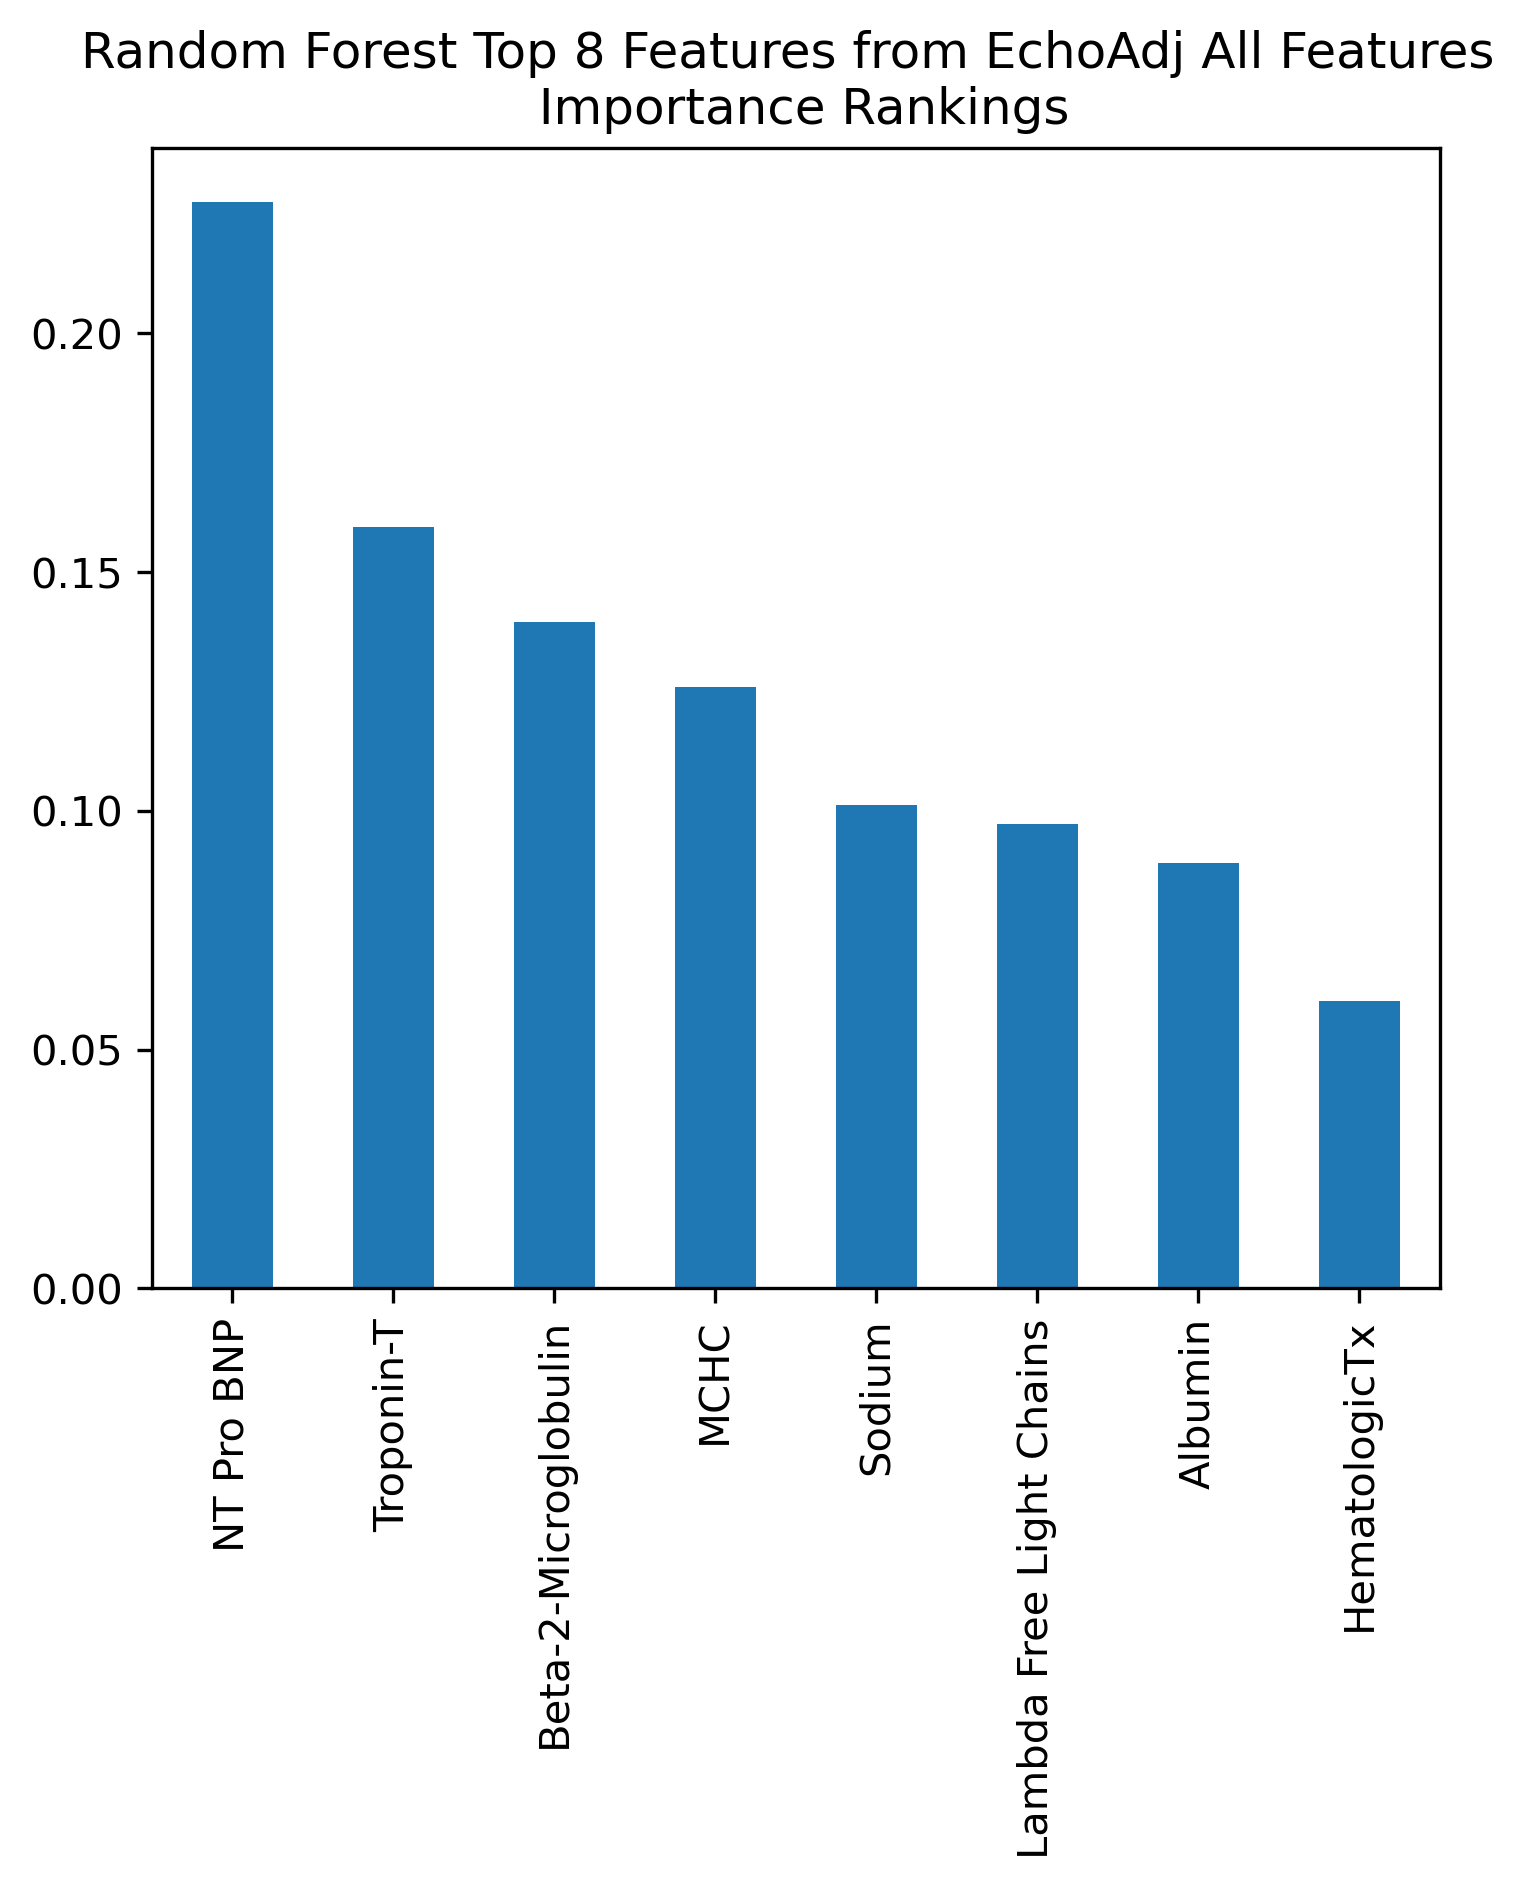

In [23]:
# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest Top 8 Features from EchoAdj All Features \n Importance Rankings")

# Show the plot
plt.show()

In [24]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
# print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print("ROC: ", roc_auc_score(y_test, y_pred))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns)
# fig, ax = plt.subplots()
# xgb_importances.plot.bar(ax=ax)
# ax.set_title("XGBoost All Features Importance Rankings")
# fig.tight_layout()

F1:  0.0
ROC:  0.2


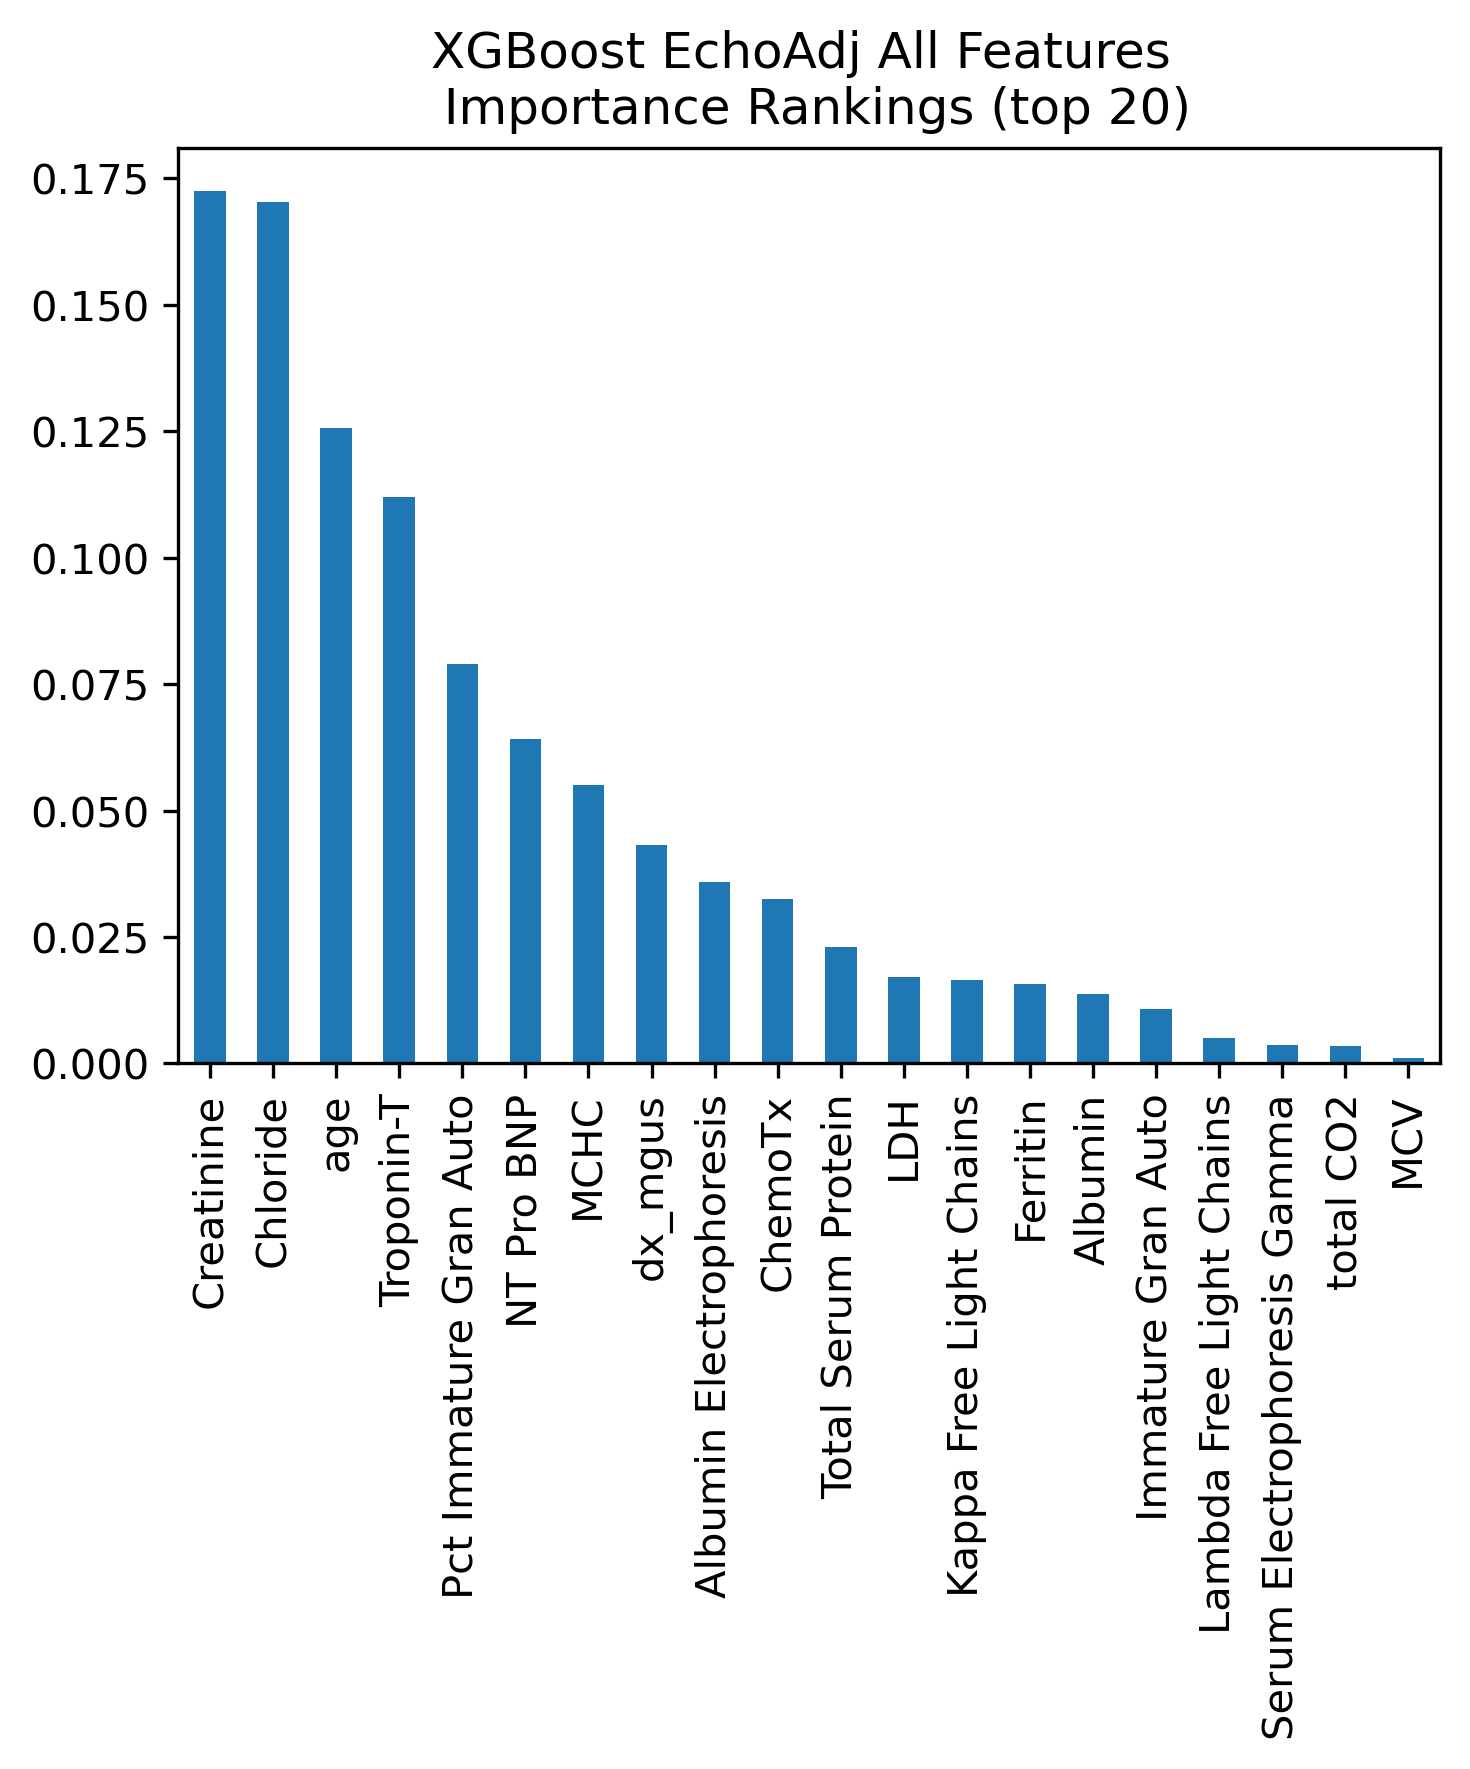

In [25]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = xgb_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("XGBoost EchoAdj All Features \n Importance Rankings (top 20)")
fig.tight_layout()

# Show the plot
plt.show()

In [26]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
# lgb_clf.predict_proba(X_test)
# print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print("ROC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 16, number of negative: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] 

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


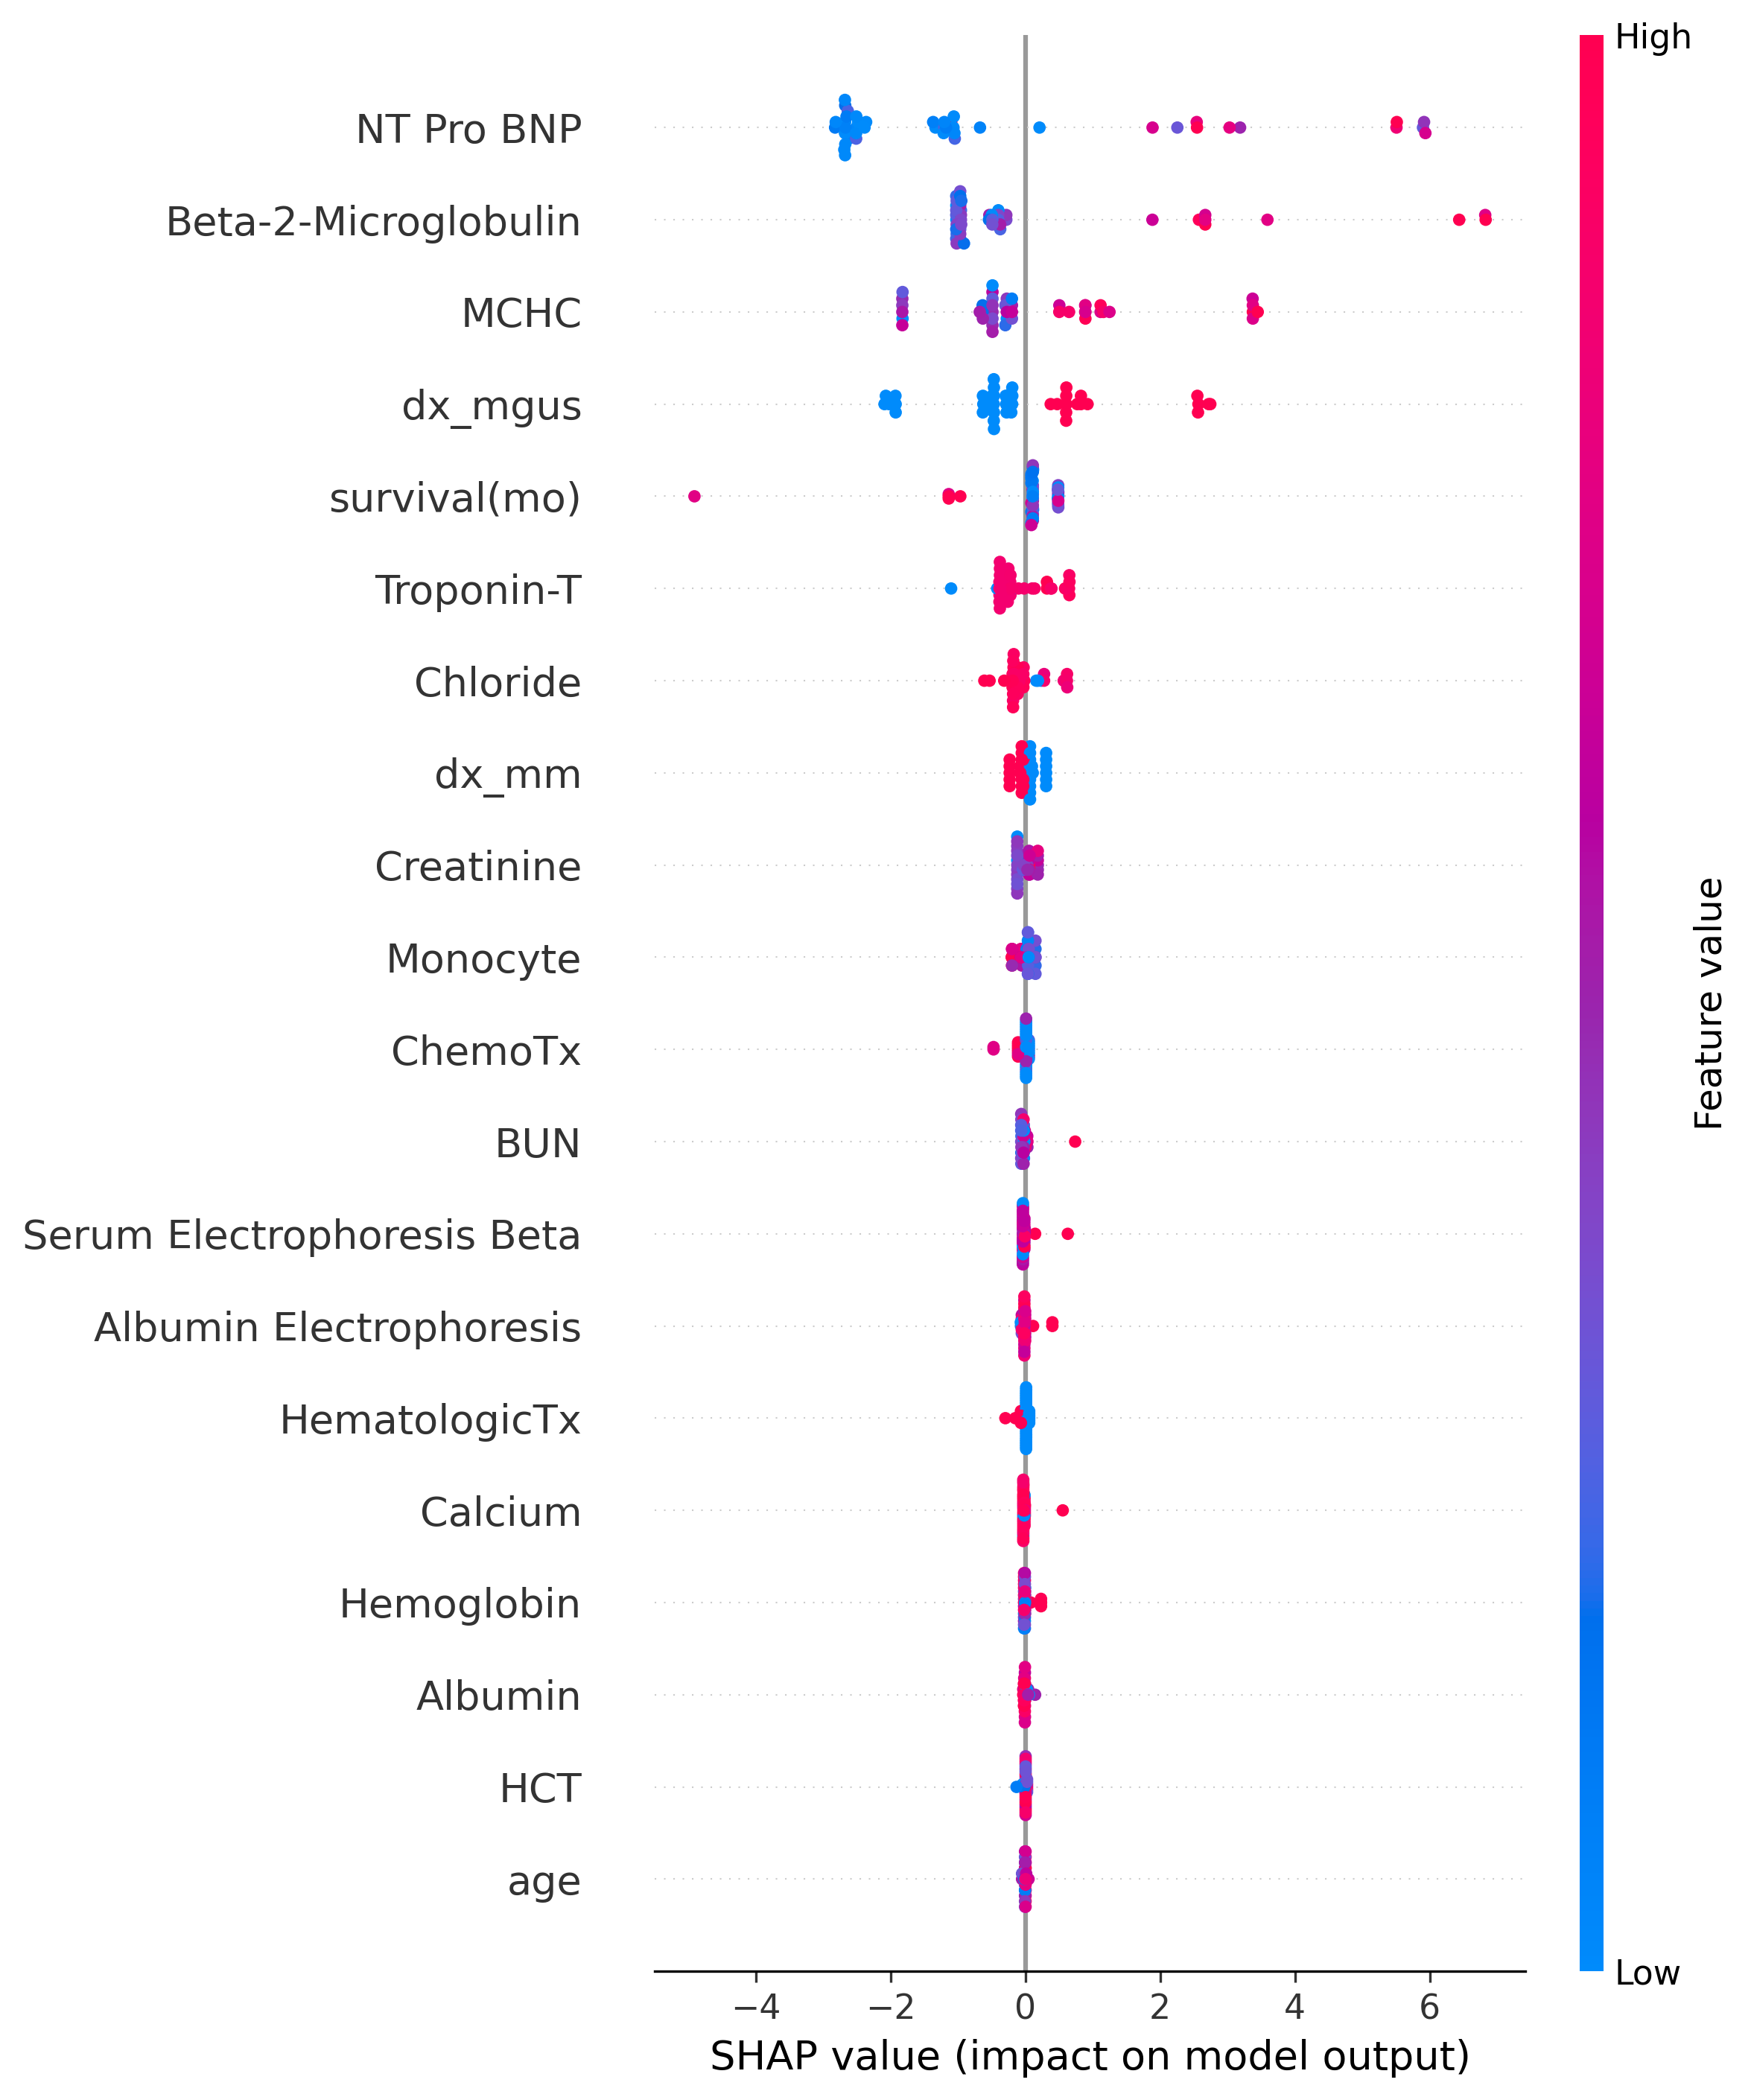

In [27]:
import shap
#borrowed from online source and edited
# create explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names = X.columns)


# bar plot for feature importances
# shap.summary_plot(shap_values_reshaped[1], X_test, plot_type="bar")

# Show the plot
plt.show()

# feature selection

In [28]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 55, Score: 0.662
Number of Features: 41, Score: 0.698
Number of Features: 30, Score: 0.679
Number of Features: 22, Score: 0.564
Number of Features: 16, Score: 0.516
Number of Features: 11, Score: 0.588
Number of Features: 8, Score: 0.280
Number of Features: 5, Score: 0.334
Number of Features: 3, Score: 0.257
Number of Features: 2, Score: 0.244
Number of Features: 1, Score: 0.257
Rank weight: 0.20
Number of Features: 55, Score: 0.662
Number of Features: 41, Score: 0.723
Number of Features: 30, Score: 0.671
Number of Features: 22, Score: 0.702
Number of Features: 16, Score: 0.627
Number of Features: 11, Score: 0.493
Number of Features: 8, Score: 0.325
Number of Features: 5, Score: 0.411
Number of Features: 3, Score: 0.257
Number of Features: 2, Score: 0.244
Number of Features: 1, Score: 0.257
Rank weight: 0.30
Number of Features: 55, Score: 0.662
Number of Features: 41, Score: 0.785
Number of Features: 30, Score: 0.708
Number of Features: 22, Score: 

# Performance plots

## F1 and AUC plots

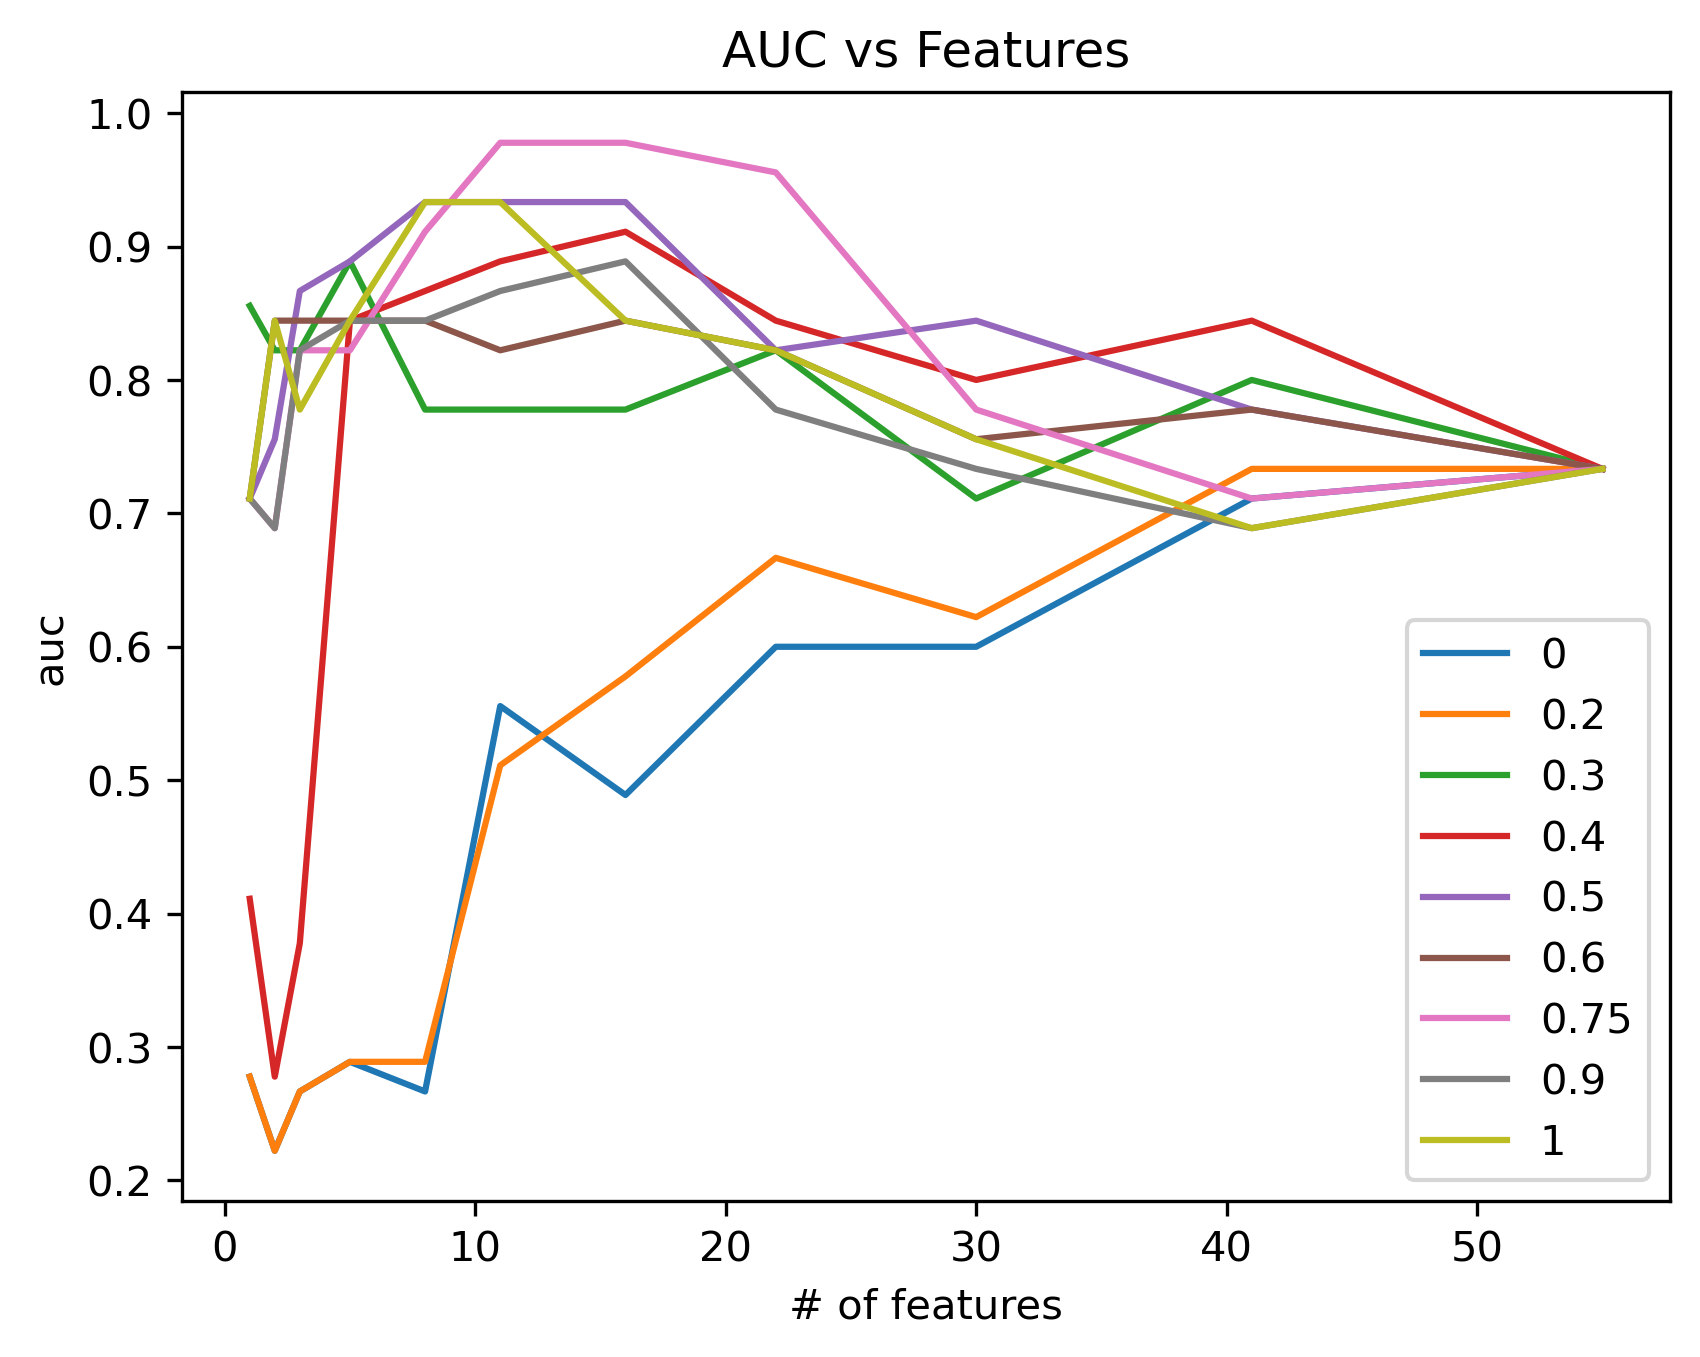

In [29]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

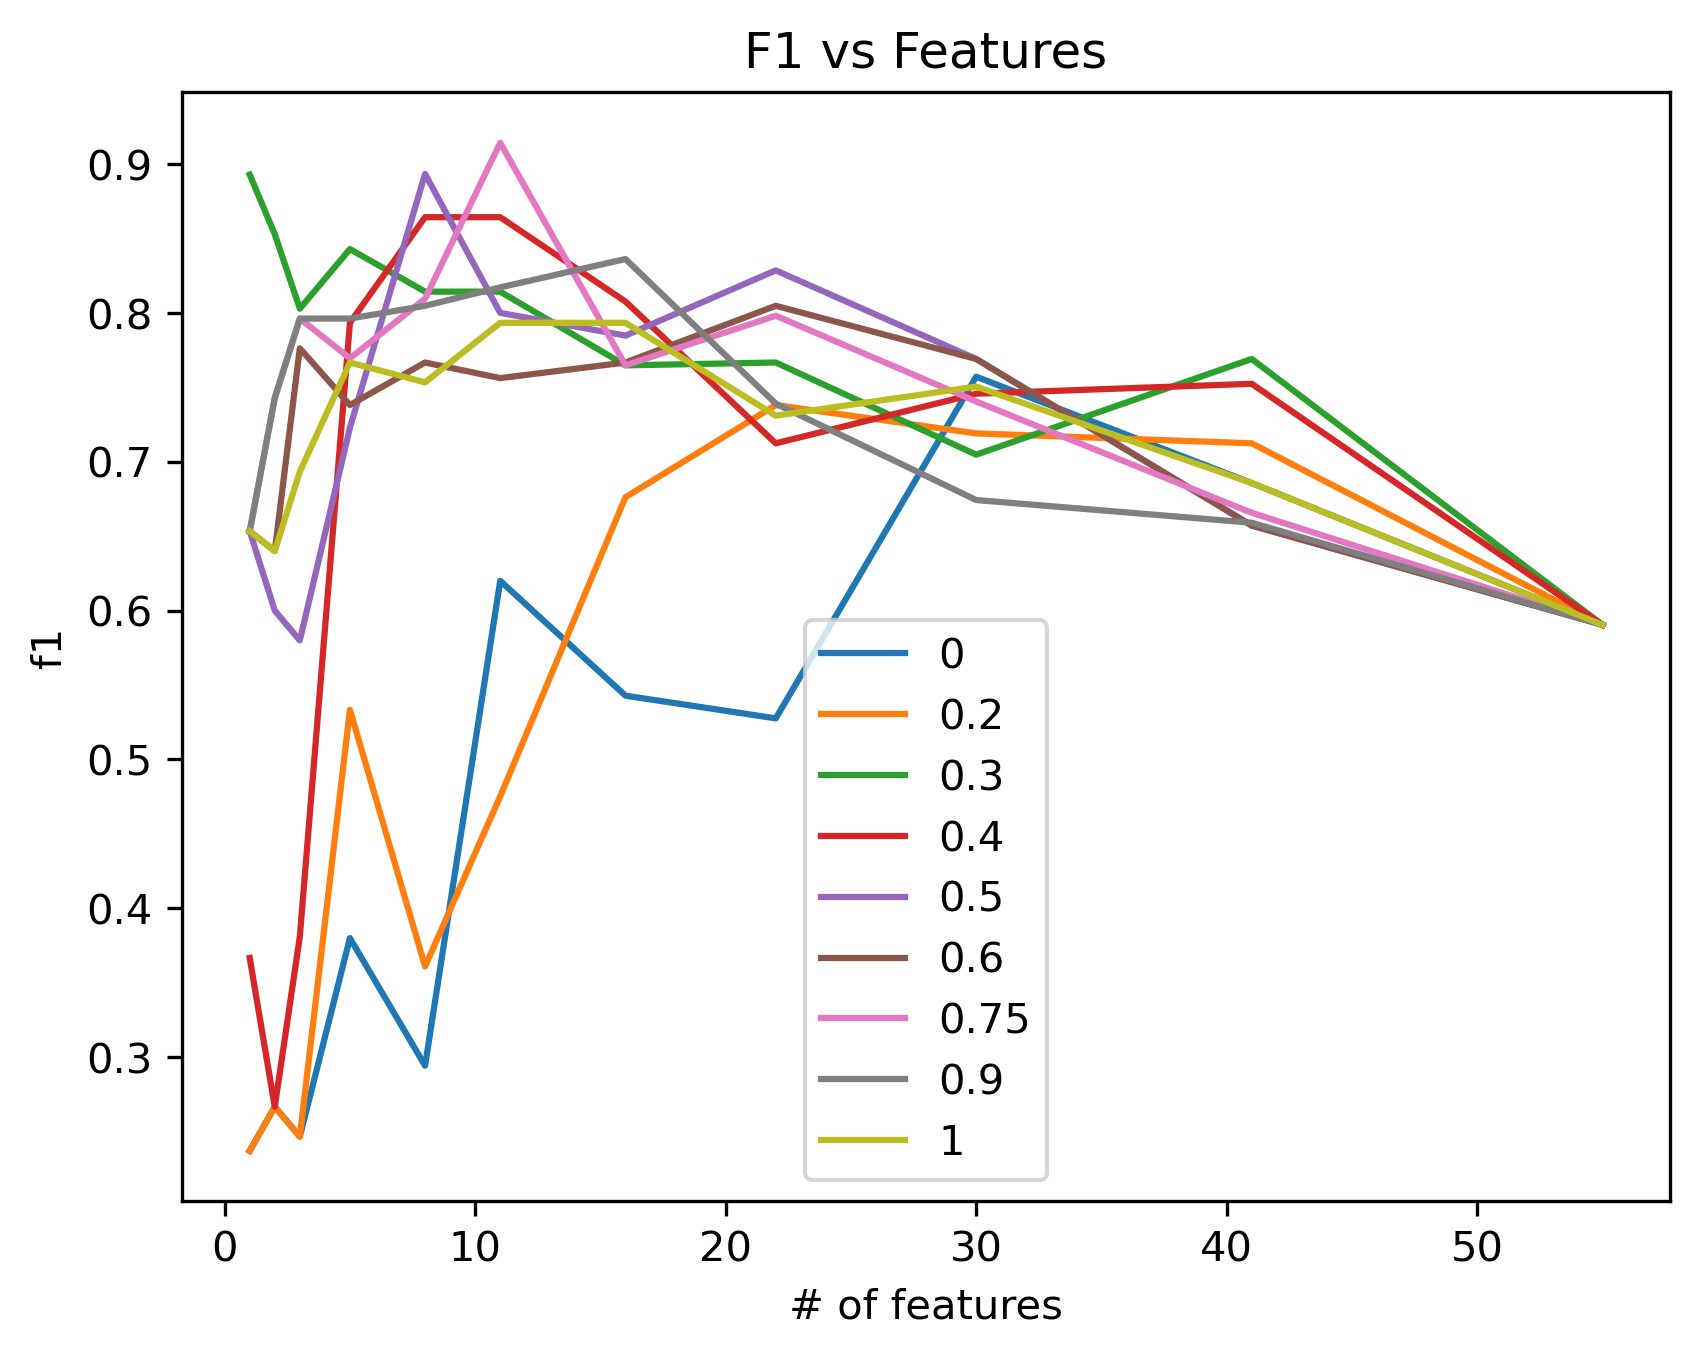

In [30]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

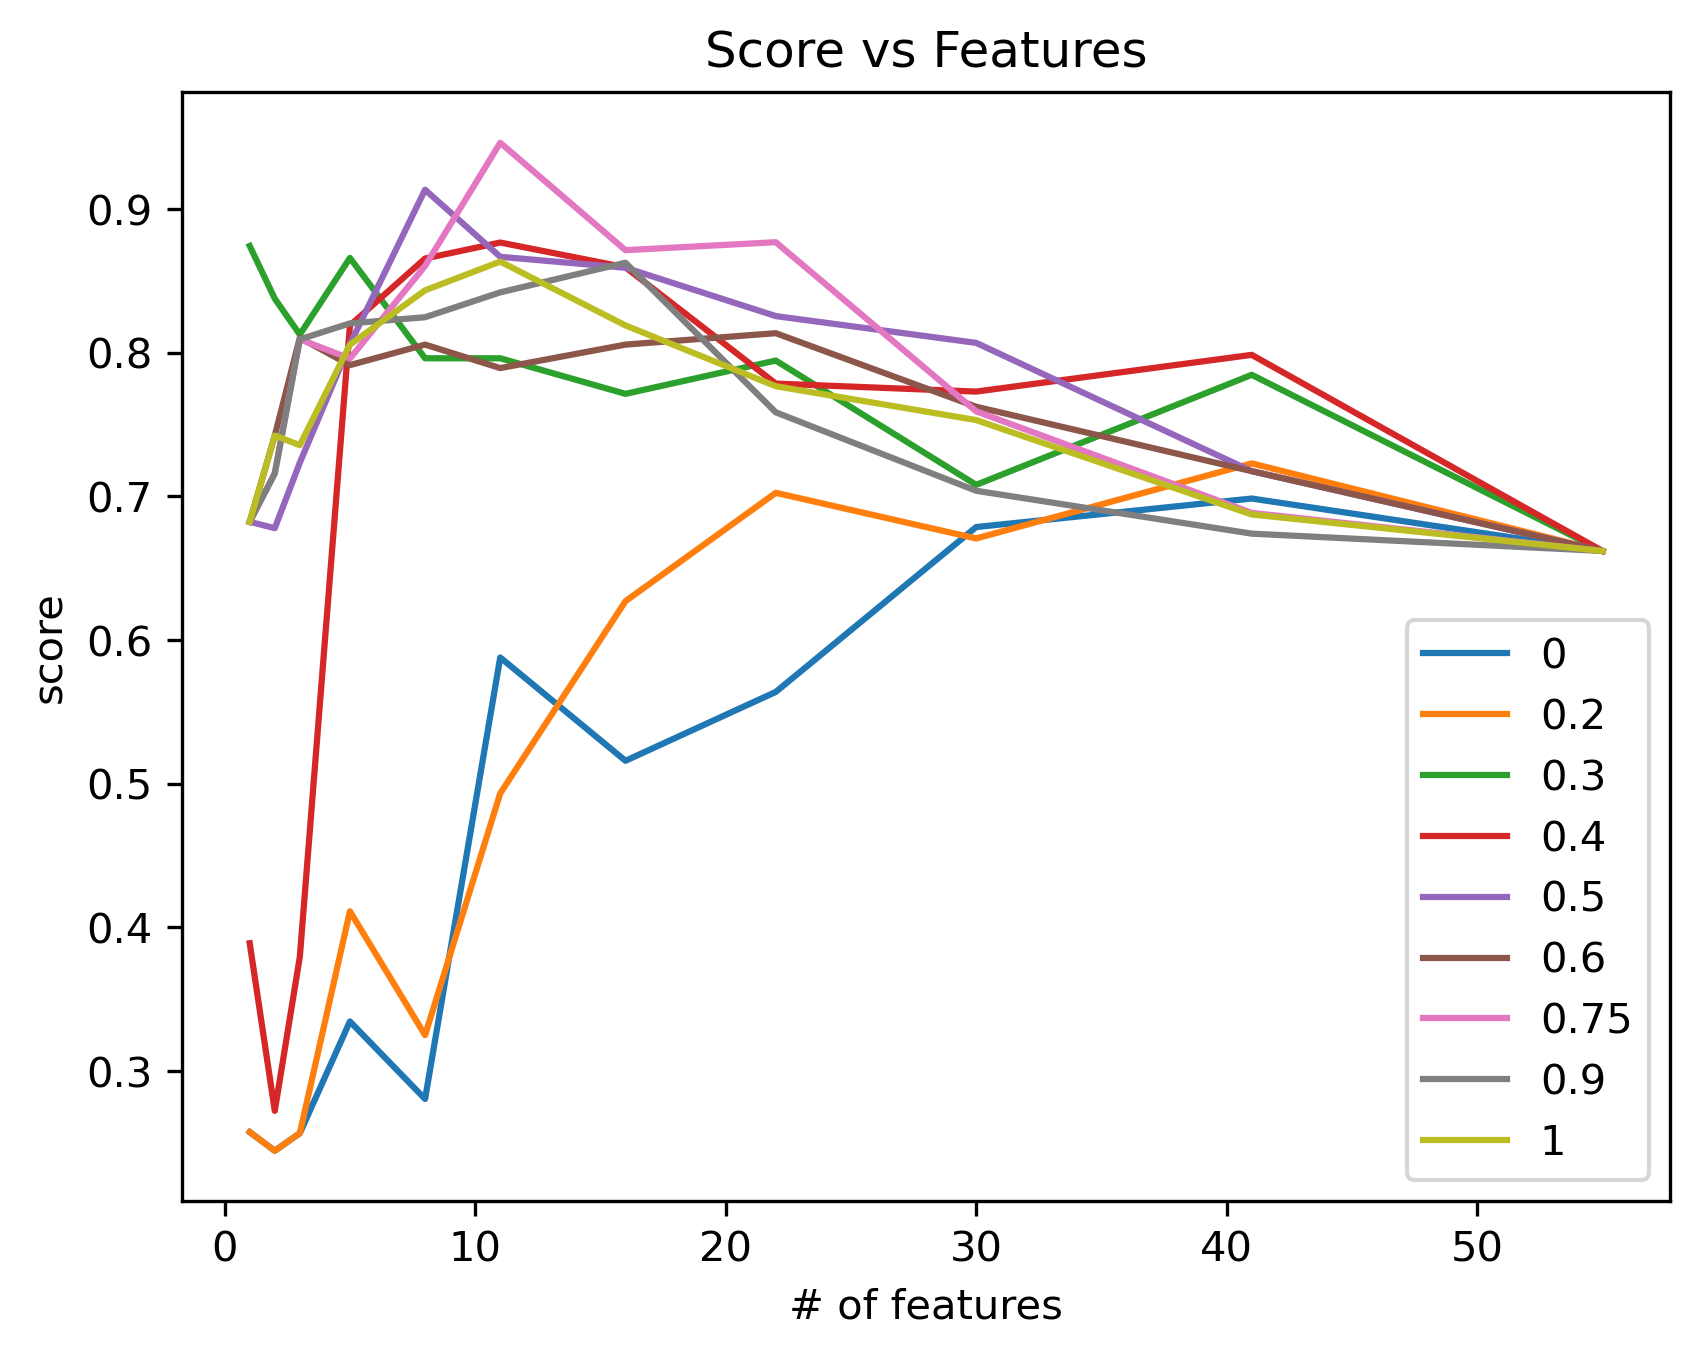

In [31]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [32]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.5705584415584415,
 0.6025194805194807,
 0.749067821067821,
 0.7512135642135641,
 0.7653354978354978,
 0.7421623376623377,
 0.7637366522366523,
 0.7265454545454546,
 0.7364025974025974]

In [33]:
svm_set_ranks[selected_run].performance_

{'f1': 0.8933333333333333,
 'auc': 0.9333333333333333,
 'score': 0.9133333333333333,
 'C': 0.25,
 'num_features': 8,
 'mean_nSV': 18.8}

In [34]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [35]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [36]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


/scratch/local/3358335/ipykernel_462169/273437511.py:36: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*precision*recall/(precision+recall)
/scratch/local/3358335/ipykernel_462169/273437511.py:36: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*precision*recall/(precision+recall)
/scratch/local/3358335/ipykernel_462169/273437511.py:33: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)
/scratch/local/3358335/ipykernel_462169/273437511.py:36: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*precision*recall/(precision+recall)


In [37]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0          NaN  0.24       4.0        1.0        5.0       0.0   
0.2        NaN  0.28       4.0        1.0        5.0       0.0   
0.3   0.500000  0.48       1.0        4.0        2.0       3.0   
0.4   0.250000  0.44       3.0        2.0        4.0       1.0   
0.5        NaN  0.56       5.0        0.0        5.0       0.0   
0.6   0.500000  0.56       1.0        4.0        2.0       3.0   
0.75  0.285714  0.52       4.0        1.0        4.0       1.0   
0.9        NaN  0.40       4.0        1.0        5.0       0.0   
1     0.363636  0.40       1.0        4.0        3.0       2.0   

      precision or PPV  recall or TPR  specificity or TNR  
0             0.000000            0.0                 0.8  
0.2           0.000000            0.0                 0.8  
0.3           0.428571            0.6                 0.2  
0.4           0.333333            0.2                 0.6  
0.5                NaN            0.0                 1.0  
0.6           0.428571            0.6                 0.2  
0.75          0.500000            0.2                 0.8  
0.9           0.000000            0.0                 0.8  
1             0.333333            0.4                 0.2

In [38]:
df_performance

f1       auc     score         C  num_features  mean_nSV
0     0.685714  0.711111  0.698413  0.500000          41.0      18.0
0.2   0.712381  0.733333  0.722857  0.500000          41.0      17.8
0.3   0.842857  0.888889  0.865873  0.031250           5.0      28.0
0.4   0.864286  0.888889  0.876587  1.000000          11.0      12.6
0.5   0.893333  0.933333  0.913333  0.250000           8.0      18.8
0.6   0.804762  0.822222  0.813492  0.015625          22.0      27.0
0.75  0.914286  0.977778  0.946032  0.125000          11.0      19.8
0.9   0.836190  0.888889  0.862540  0.125000          16.0      19.4
1     0.793333  0.933333  0.863333  0.015625          11.0      28.0

In [39]:
df_features

0                                  0.2  \
0                      sex_female                           sex_female   
1                             age                                  age   
2                    survival(mo)                         survival(mo)   
3                         ChemoTx                              ChemoTx   
4                   HematologicTx                        HematologicTx   
5                     RadiationTx                          RadiationTx   
6                         OtherTx                              OtherTx   
7              HematologicTx_True                   HematologicTx_True   
8                RadiationTx_True                     RadiationTx_True   
9                    OtherTx_True                         OtherTx_True   
10                            ALT                                  ALT   
11                            AST                                  AST   
12        Albumin Electrophoresis              Albumin Electrophoresis   
13                        Albumin                              Albumin   
14                            BUN                                  BUN   
15                        Calcium                              Calcium   
16                       Chloride                             Chloride   
17                       Ferritin                             Ferritin   
18                        Glucose                              Glucose   
19                            HCT                                  HCT   
20                     Hemoglobin                           Hemoglobin   
21             Immature Gran Auto                   Immature Gran Auto   
22                            LDH              Kappa Free Light Chains   
23       Lambda Free Light Chains  Kappa/Lambda Free Light Chain Ratio   
24                            MCH                                  LDH   
25                           MCHC                                  MCH   
26                            MCV                                 MCHC   
27                       Monocyte                                  MCV   
28                     Neutrophil                             Monocyte   
29                 Pct Neutrophil                       Platelet Count   
30                      Potassium                            Potassium   
31                            RBC                                  RBC   
32  Serum Electrophoresis Alpha 1        Serum Electrophoresis Alpha 1   
33  Serum Electrophoresis Alpha 2        Serum Electrophoresis Alpha 2   
34     Serum Electrophoresis Beta           Serum Electrophoresis Beta   
35                         Sodium                               Sodium   
36            Total Serum Protein                  Total Serum Protein   
37                            WBC                                  WBC   
38                      total CO2                            total CO2   
39                     NT Pro BNP                           NT Pro BNP   
40                     Troponin-T                           Troponin-T   

                   0.3                            0.4  \
0              ChemoTx                            age   
1   HematologicTx_True                        ChemoTx   
2             Chloride                  HematologicTx   
3             Ferritin             HematologicTx_True   
4                  RBC                            ALT   
5                  NaN        Albumin Electrophoresis   
6                  NaN                            BUN   
7                  NaN                       Ferritin   
8                  NaN                            LDH   
9                  NaN  Serum Electrophoresis Alpha 1   
10                 NaN                     NT Pro BNP   
11                 NaN                            NaN   
12                 NaN                            NaN   
13                 NaN                            NaN   
14                 NaN                            NaN   
15         

## best model performance

In [40]:
print("rank weights: ", str(rank_weights[selected_run]))
print(df_performance.iloc[selected_run])
print(df_blindprediction.iloc[selected_run])

rank weights:  0.5
f1               0.893333
auc              0.933333
score            0.913333
C                0.250000
num_features     8.000000
mean_nSV        18.800000
Name: 0.5, dtype: float64
f1                     NaN
auc                   0.56
true neg              5.00
false pos             0.00
false neg             5.00
true pos              0.00
precision or PPV       NaN
recall or TPR         0.00
specificity or TNR    1.00
Name: 0.5, dtype: float64


In [41]:
df_features[str(rank_weights[selected_run])].dropna()

0                              age
1                          ChemoTx
2                    HematologicTx
3               HematologicTx_True
4                              AST
5                         Chloride
6    Serum Electrophoresis Alpha 2
7                       NT Pro BNP
Name: 0.5, dtype: object

## pair plots

In [42]:
X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values

array(['NT Pro BNP', 'AST', 'HematologicTx_True', 'HematologicTx', 'age',
       'Serum Electrophoresis Alpha 2', 'Chloride', 'ChemoTx'],
      dtype=object)

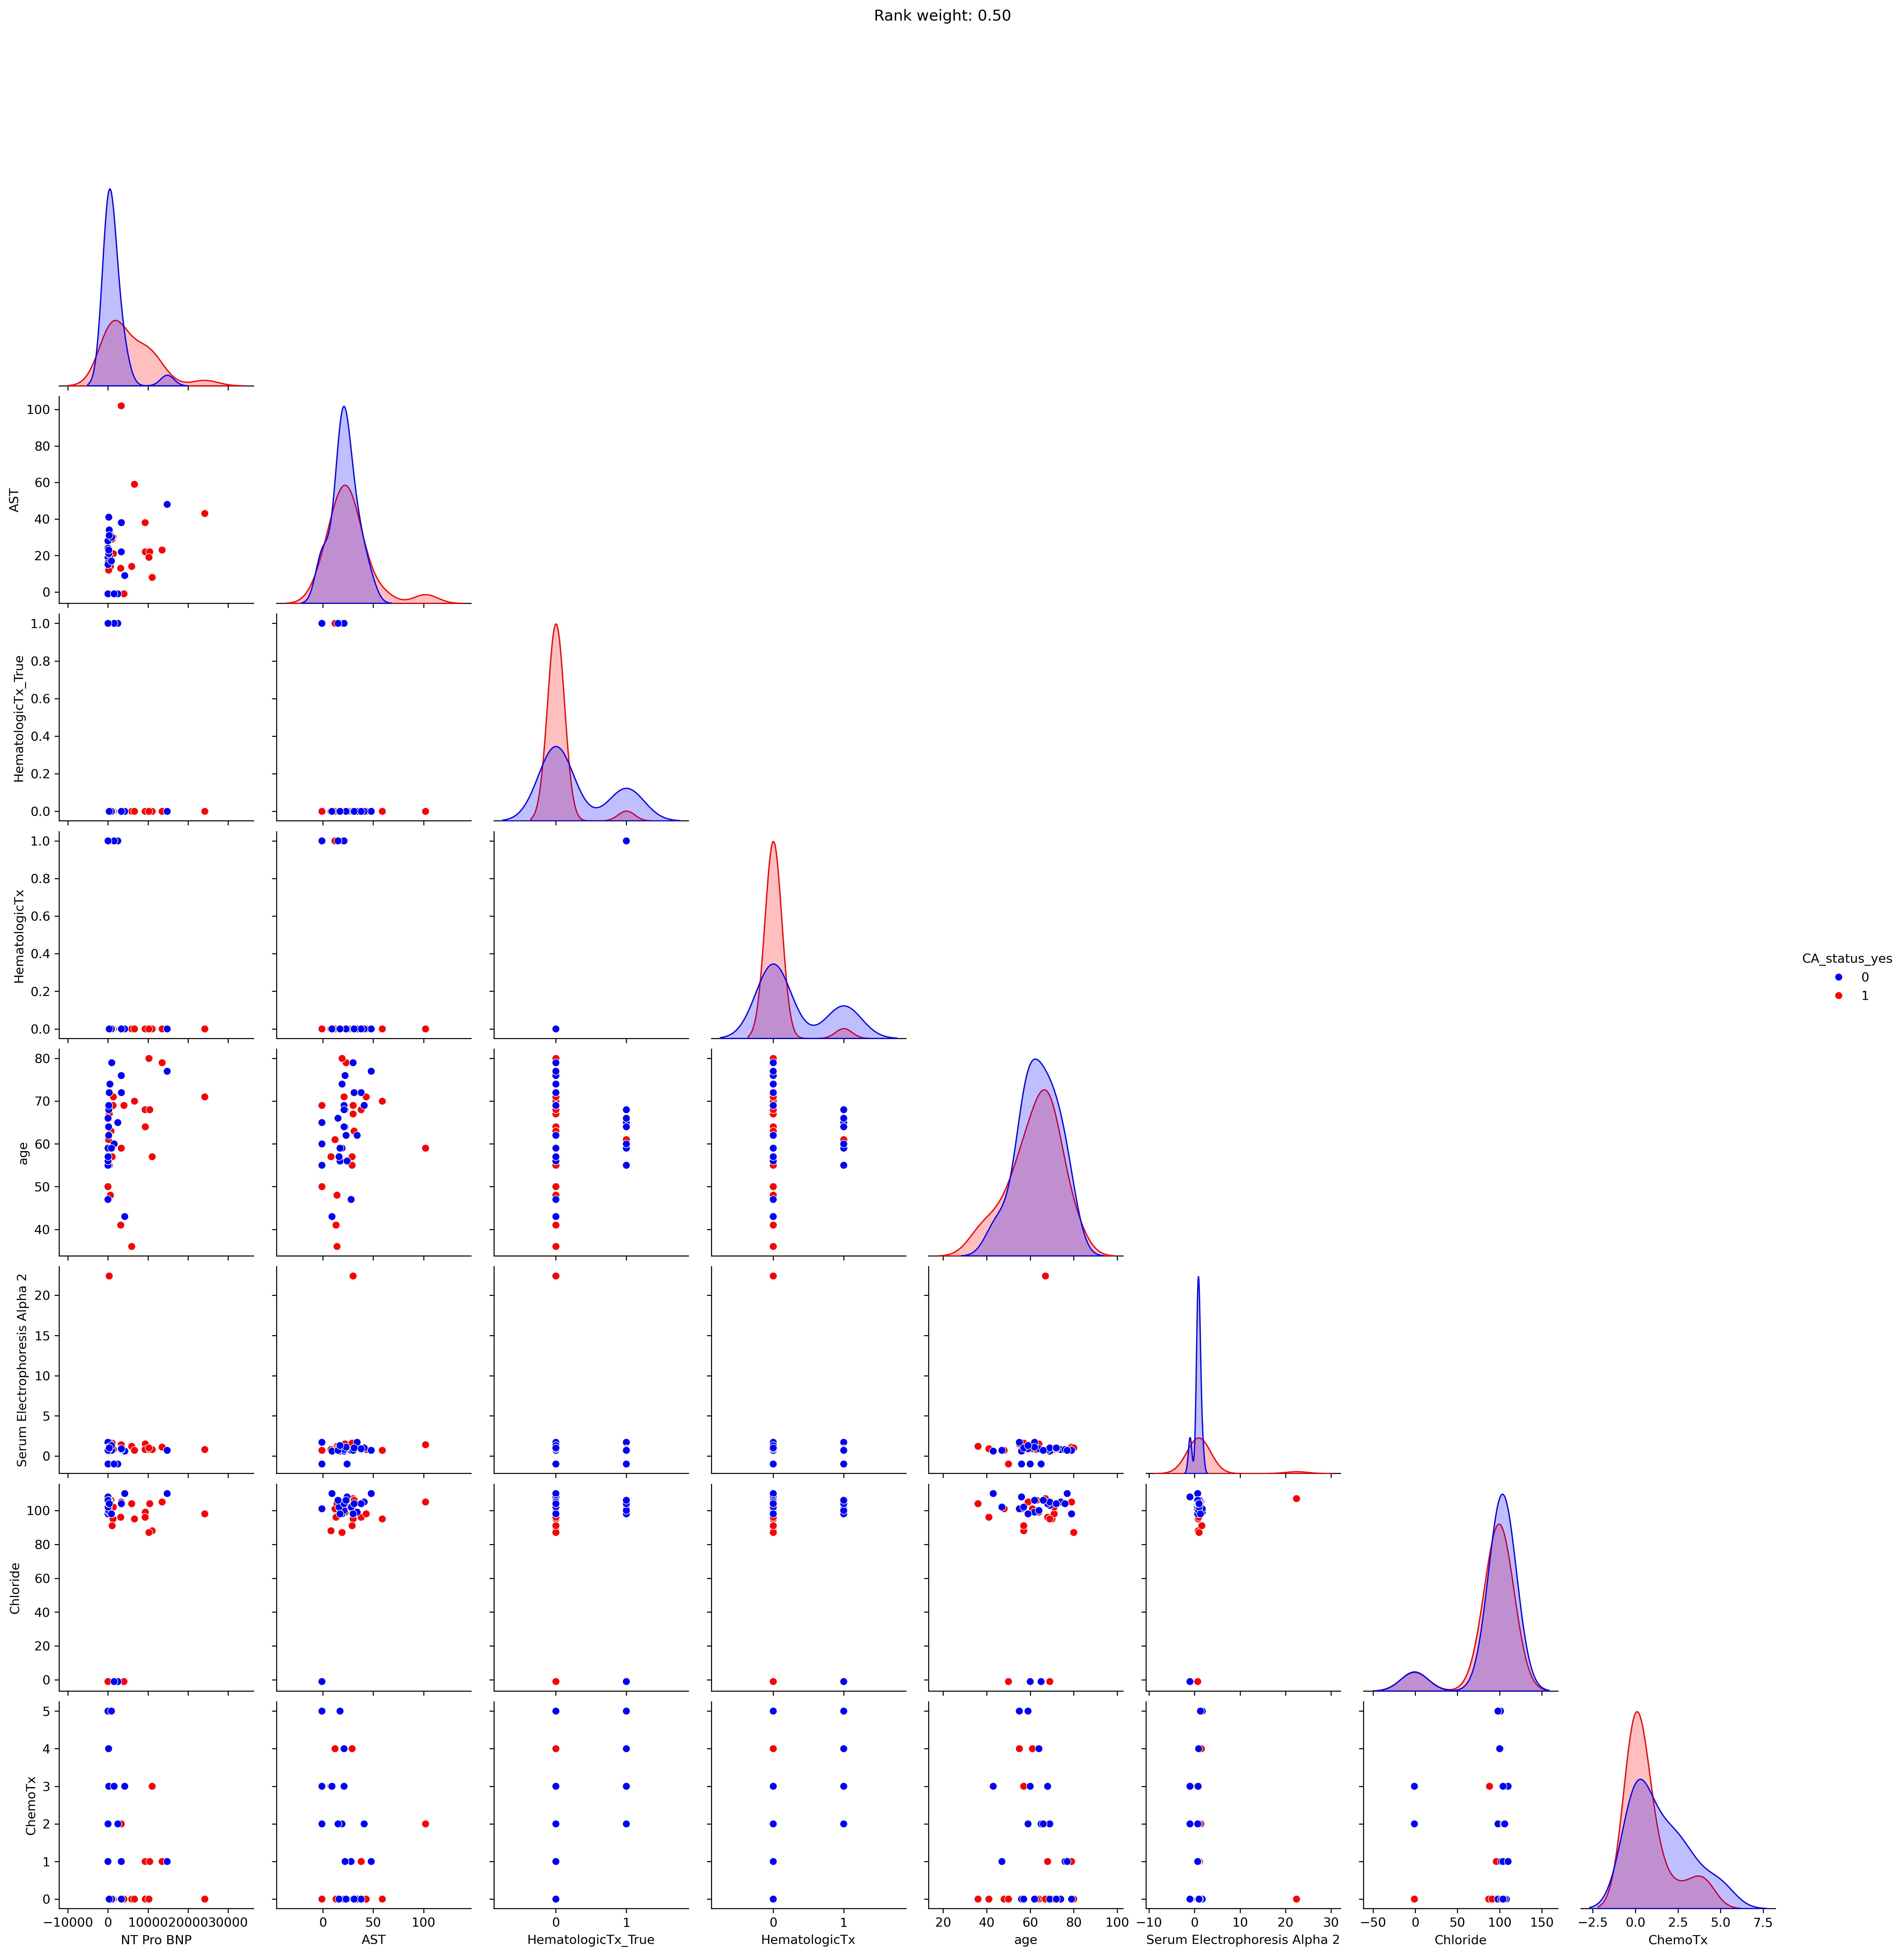

In [43]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

In [44]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [45]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



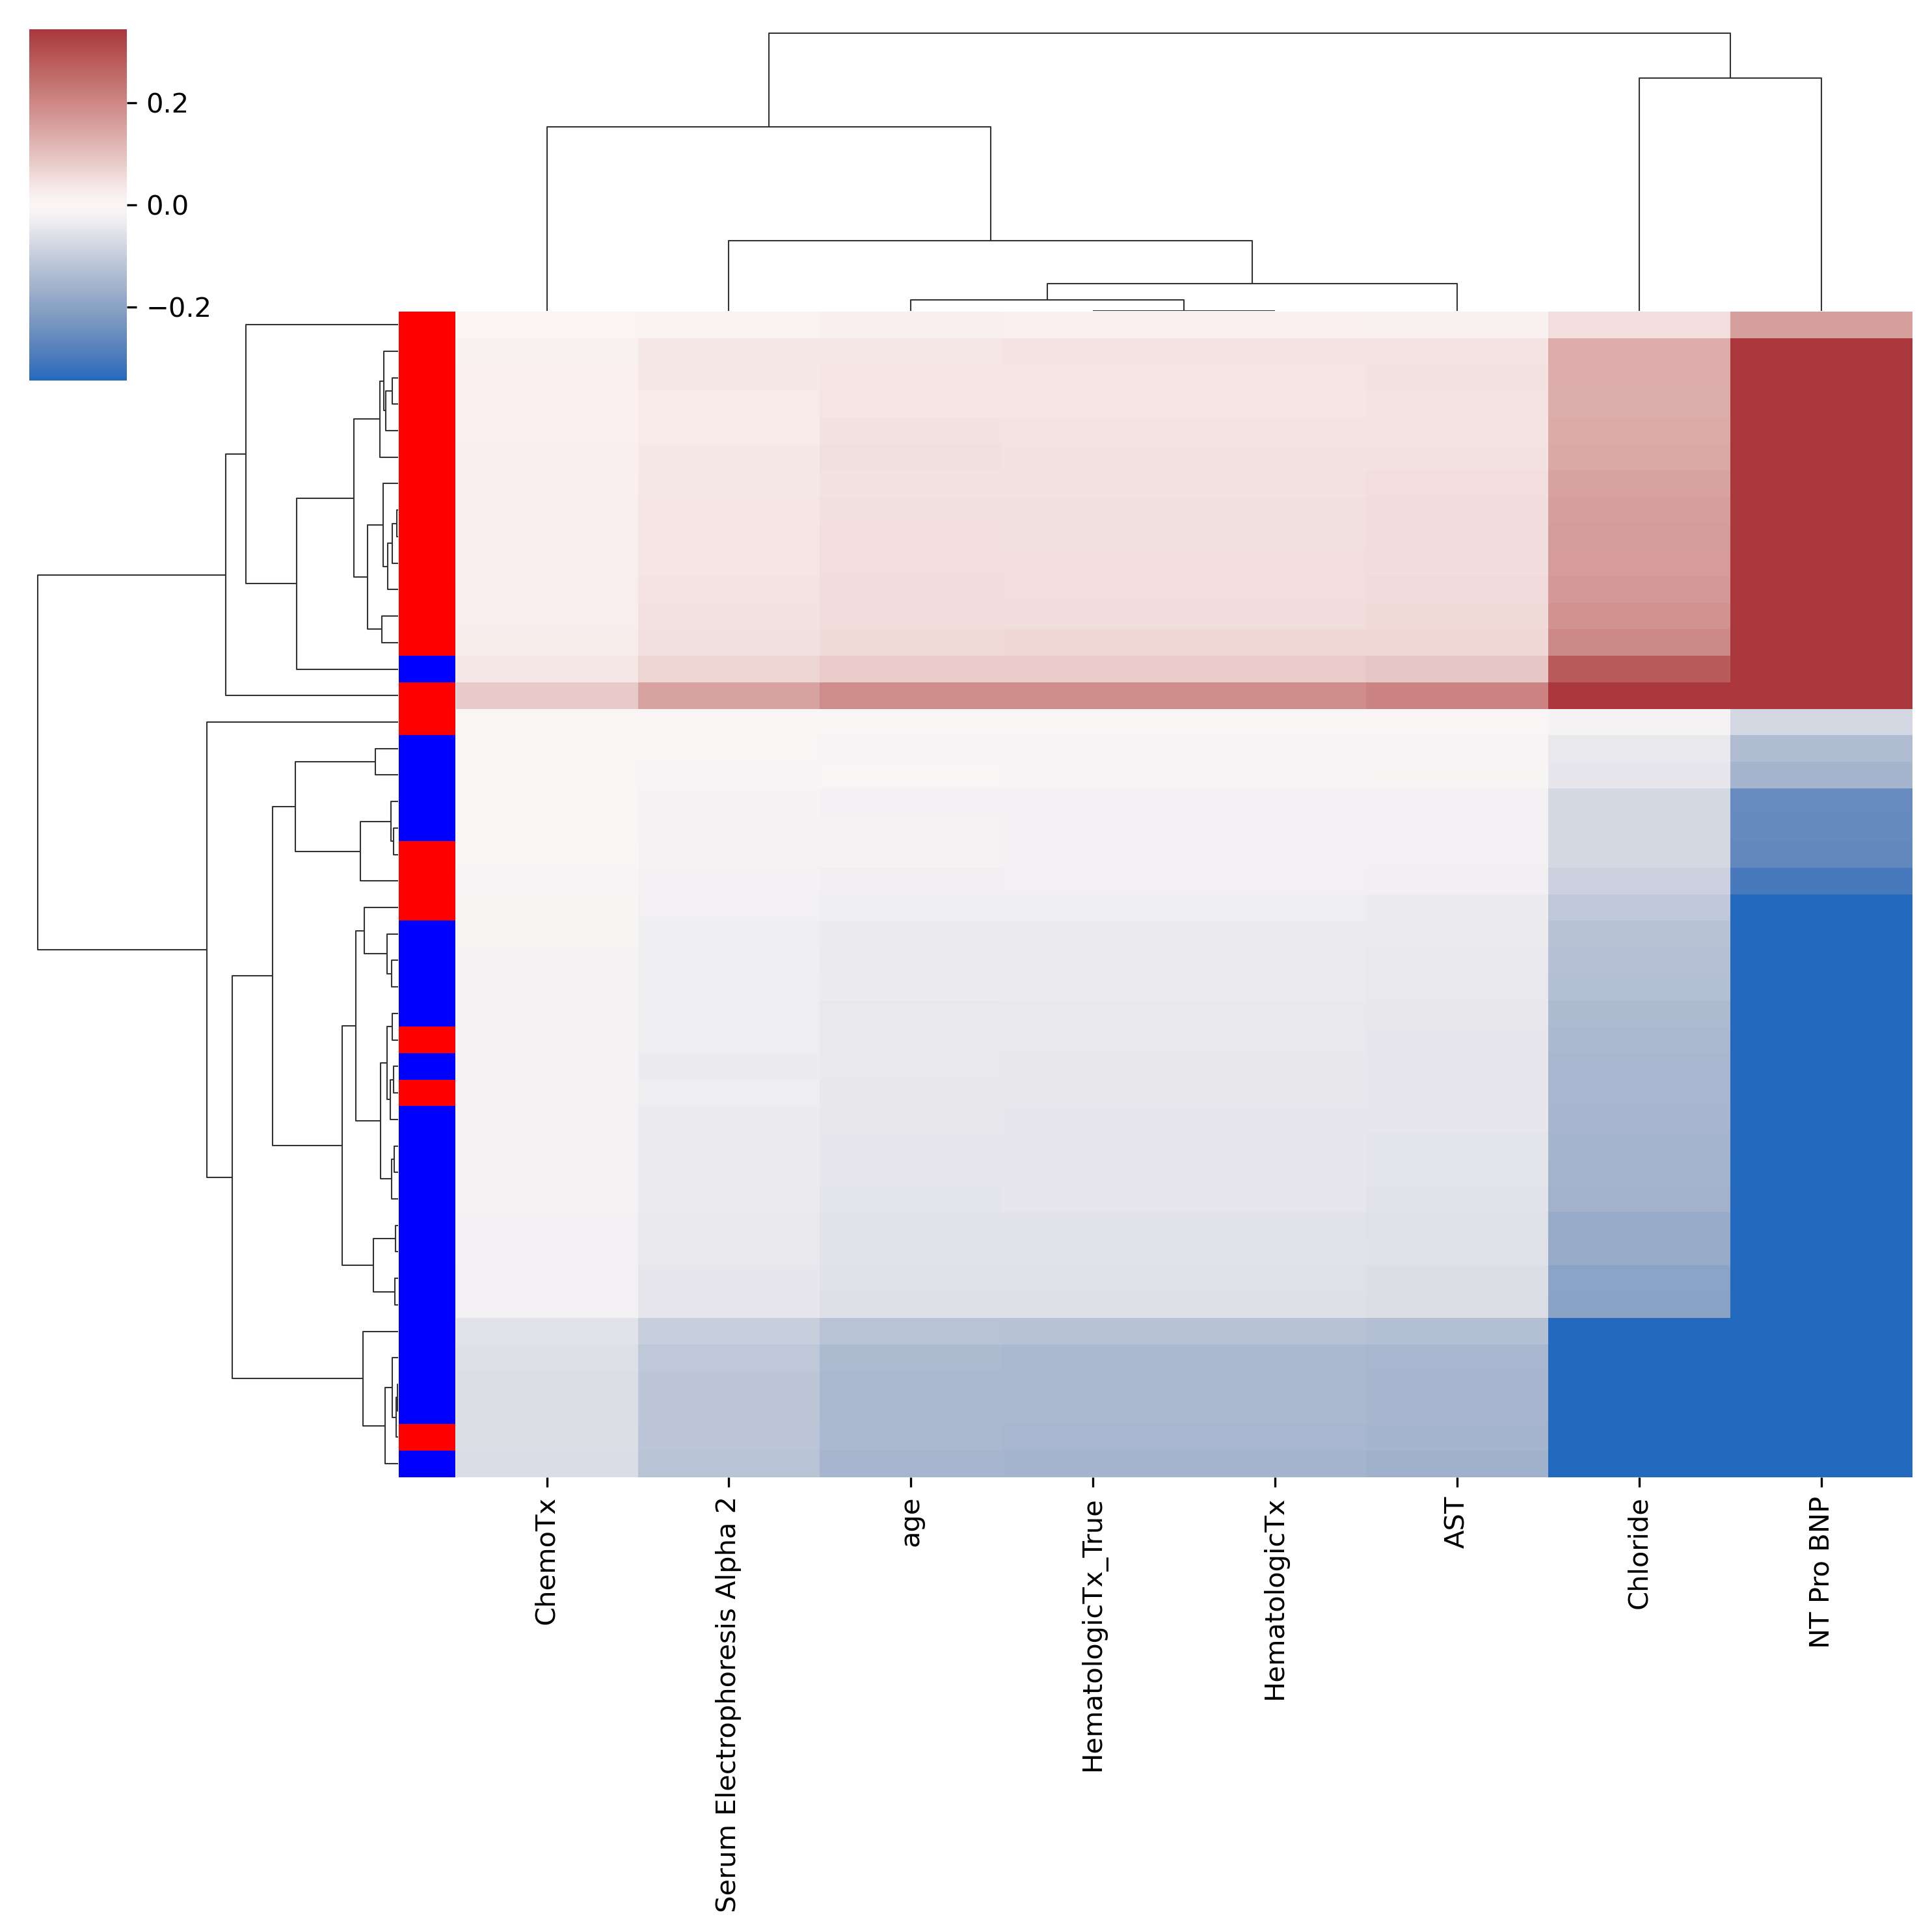

In [46]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

In [47]:
X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values

array(['NT Pro BNP', 'AST', 'HematologicTx_True', 'HematologicTx', 'age',
       'Serum Electrophoresis Alpha 2', 'Chloride', 'ChemoTx'],
      dtype=object)

In [48]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=600,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [49]:
nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=2000,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [50]:
feat_1 = IGtable.columns[feature_order[0]]
feat_2 = IGtable.columns[feature_order[1]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

In [51]:
# feat_1 = IGtable.columns[feature_order[5]]
# feat_2 = IGtable.columns[feature_order[6]]

# fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
# fig.update_traces(marker=dict(size=12))

# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=800,
#     height=800,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = feat_1,
#     yaxis_title = "Integrated Gradient for " + feat_1,
#     font=dict(size=20)
# )

# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
#     )
    
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
# )

# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text=feat_2,side = "right"),
#                     cmin = -1, cmax = 1)

# fig.show()

# sensitivity and specificity 

In [52]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

True Negative:  5
false positive:  0
false negative:  5
true positive:  0
true positive rate or recall/sensitivity:  0.0
positive predictive value or precision:  nan
specificity or true negatie rate:  1.0
auc:  0.56
f1 score:  nan


/scratch/local/3358335/ipykernel_462169/3912270694.py:5: RuntimeWarning:

invalid value encountered in scalar divide



# testing alt models on best feature list

In [53]:
X_all_trim = X_all[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_train_trim = X_train[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_test_trim = X_test[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
#making the dataset only include the features from the best performing model in SVM

In [54]:
cv_set_trim = cvSet(X = X_train_trim, y = y_train.values)
cv_set_trim.classification(num_sets = numb_sets)

F1:  0.2857142857142857
ROC:  0.5


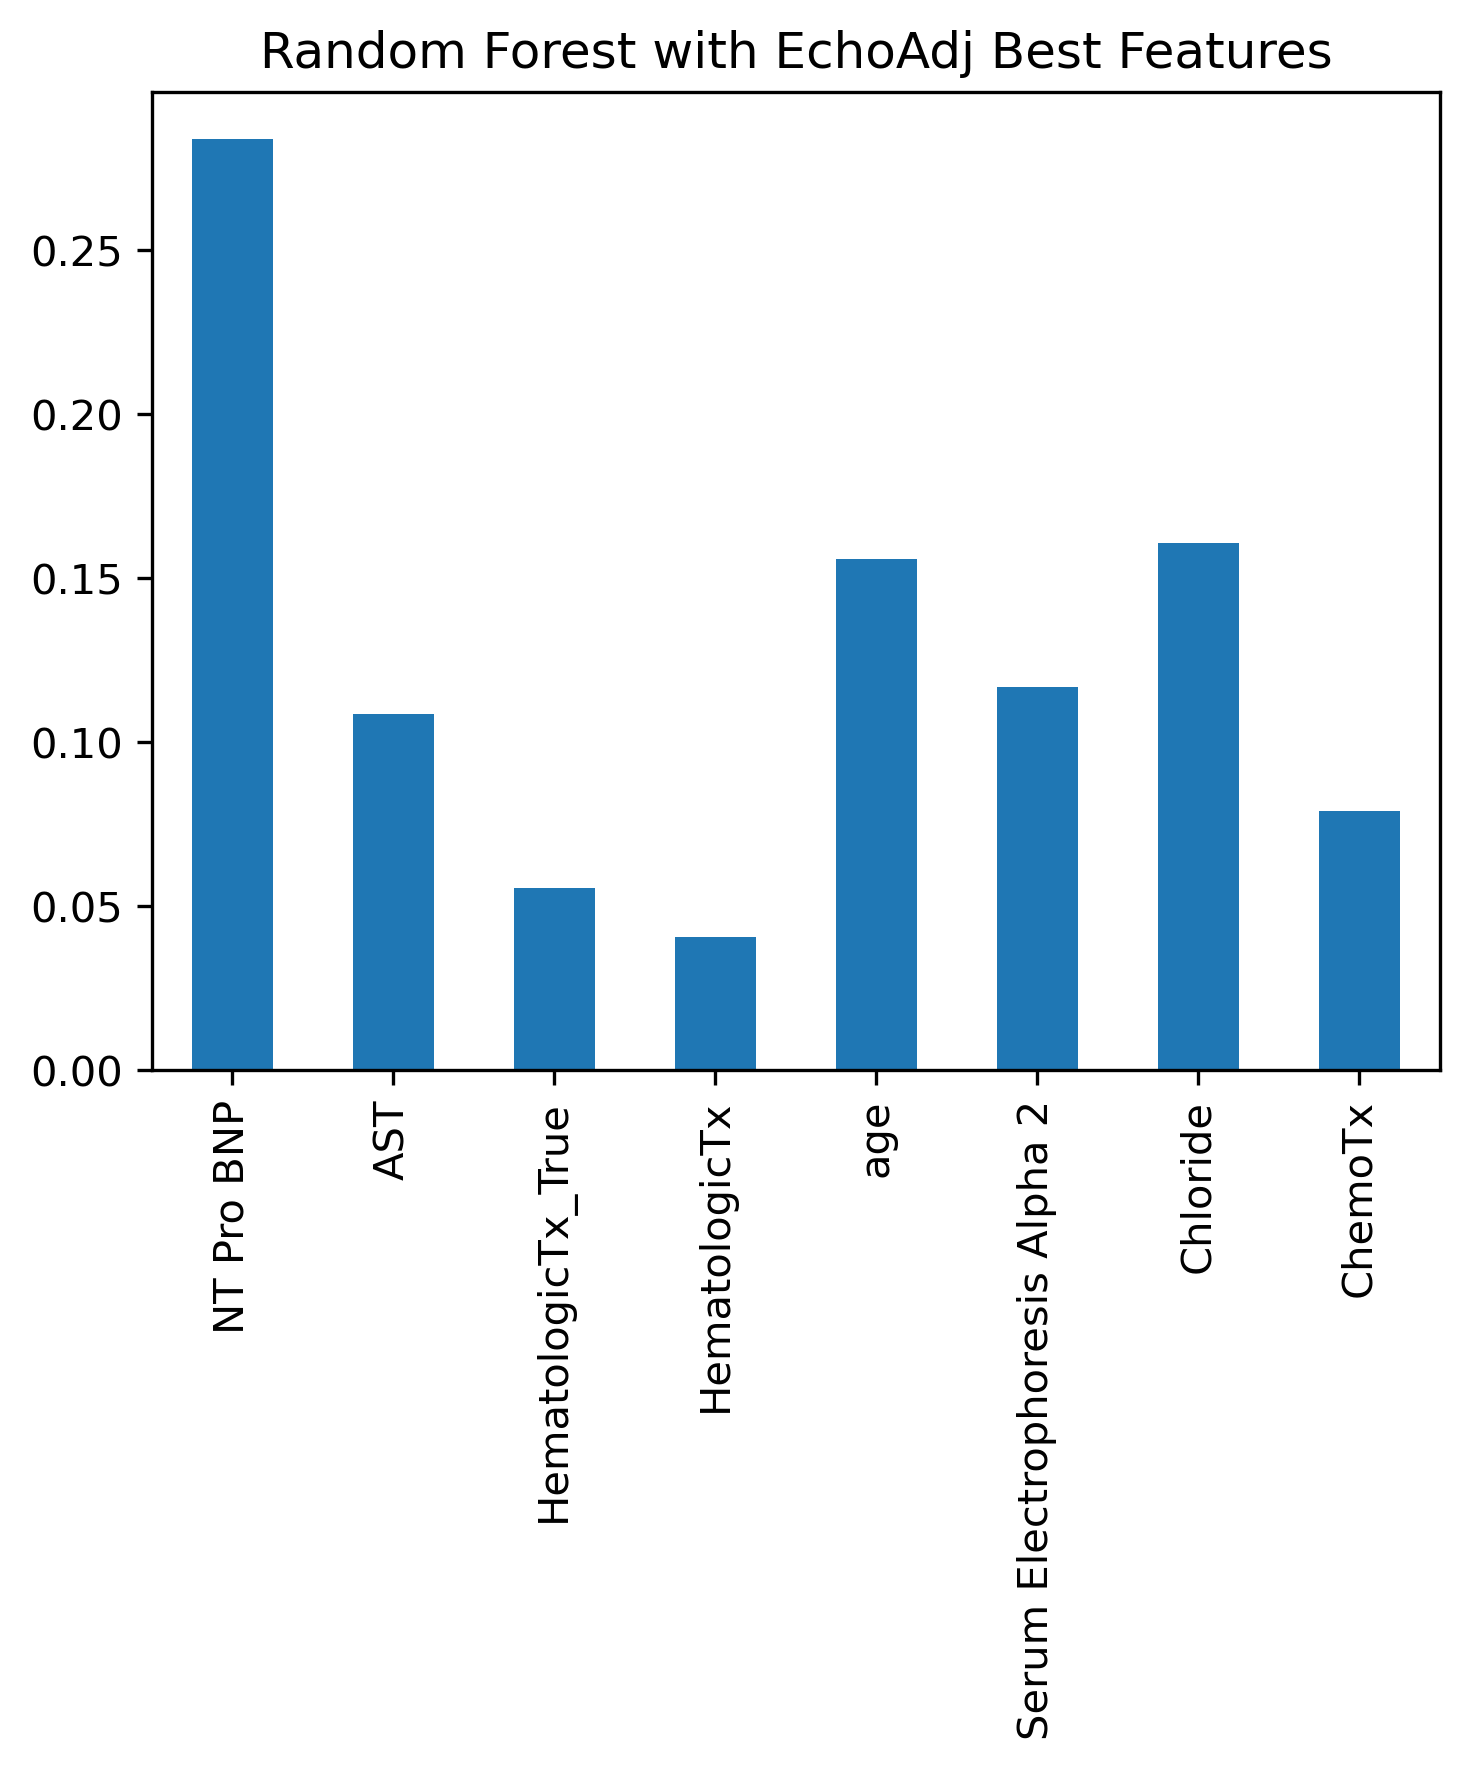

In [55]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train_trim, y_train)
y_pred = rnd_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print("ROC: ", roc_auc_score(y_test, y_pred))

importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest with EchoAdj Best Features")
fig.tight_layout()

F1:  0.2857142857142857
ROC:  0.5


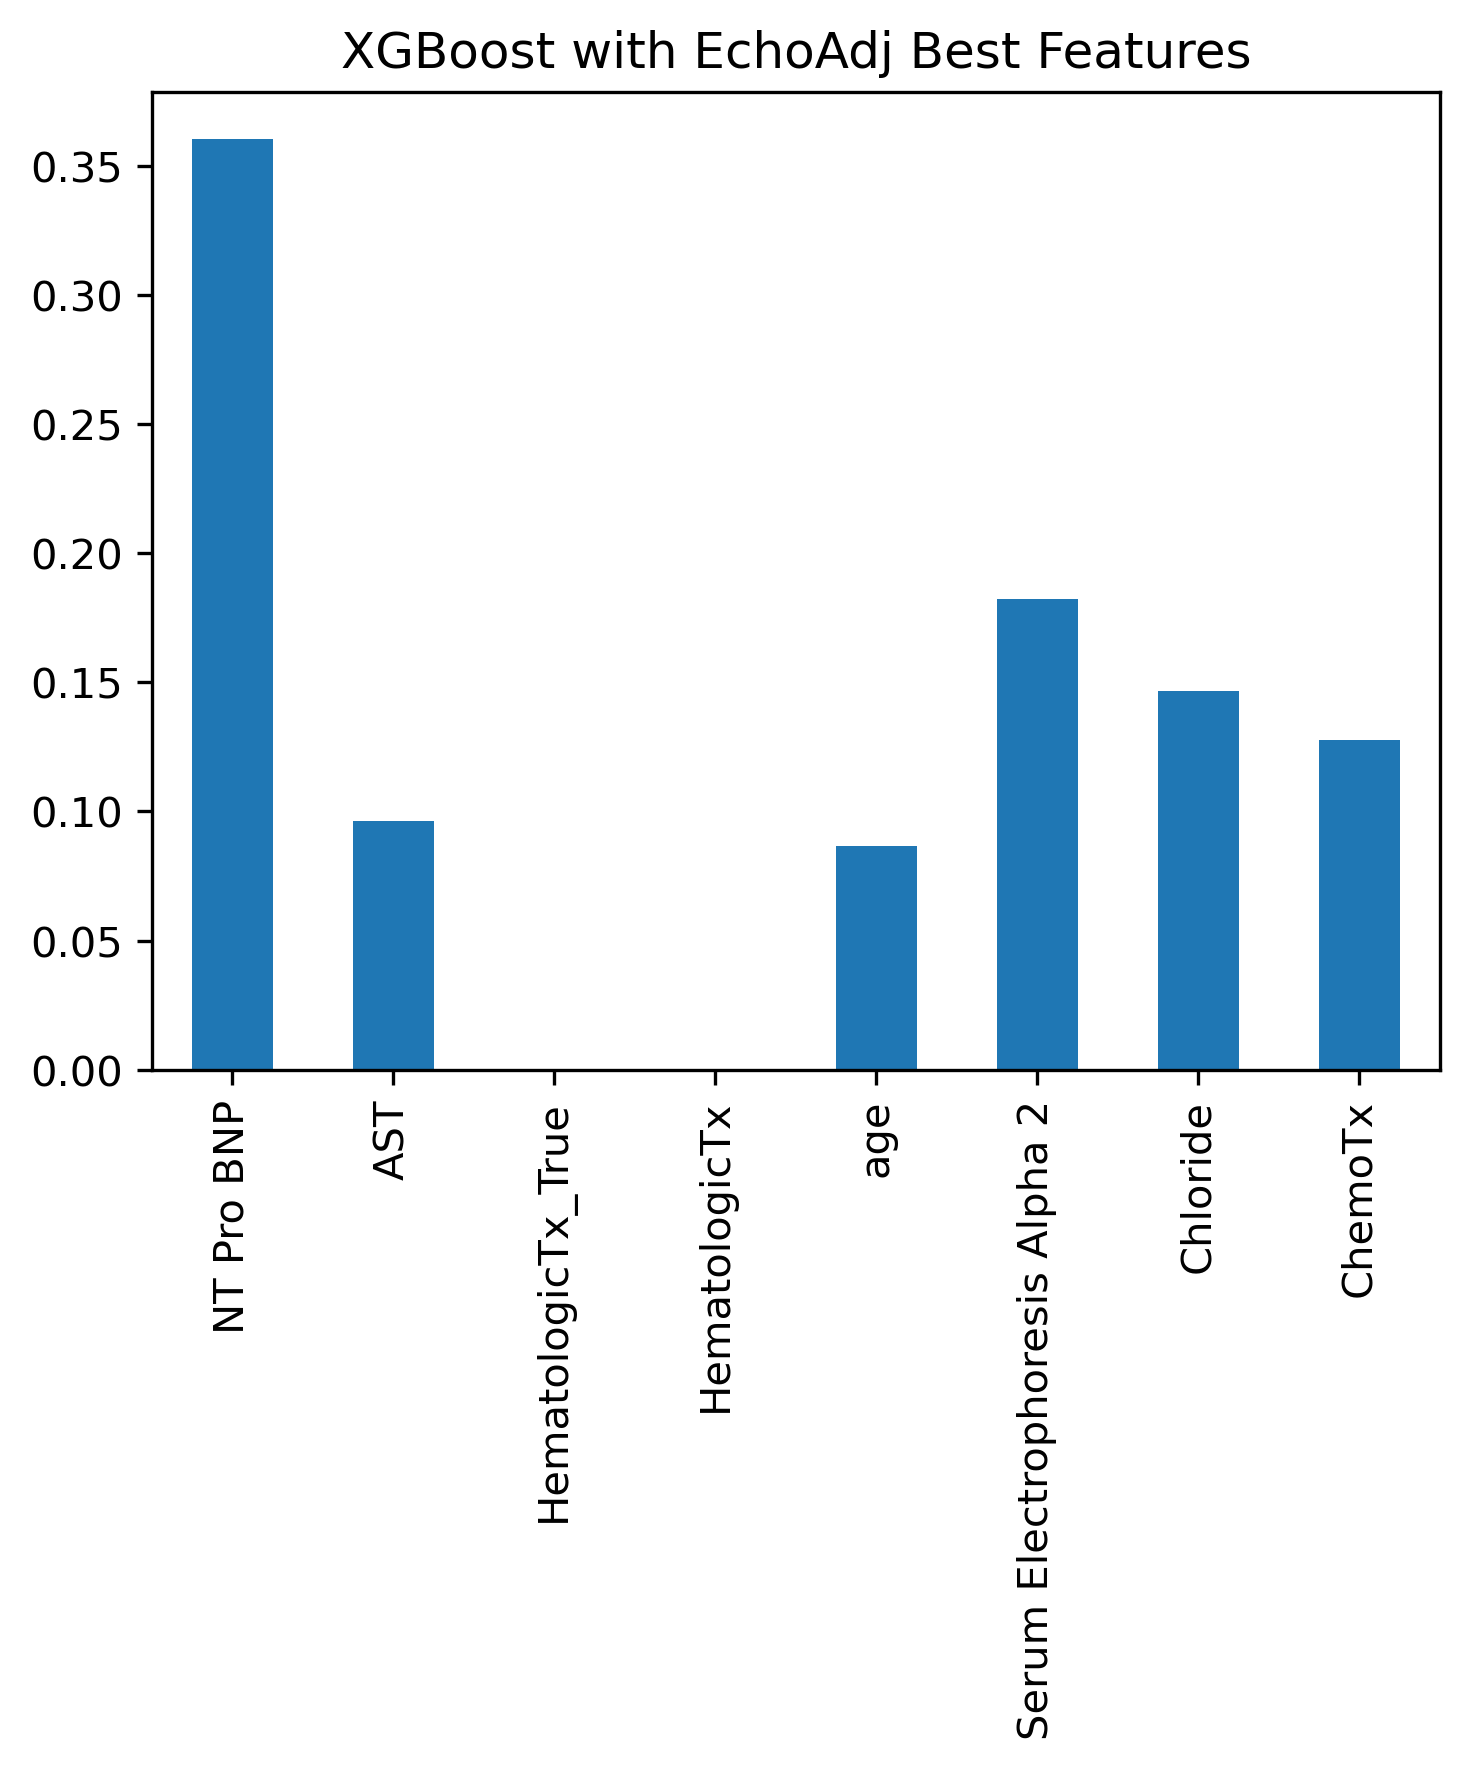

In [56]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_trim, y_train)
y_pred = xgb_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print("ROC: ", roc_auc_score(y_test, y_pred))


importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with EchoAdj Best Features")
fig.tight_layout()

In [57]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train_trim, y_train)
y_pred = lgb_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print("ROC: ", roc_auc_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 16, number of negative: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] St

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



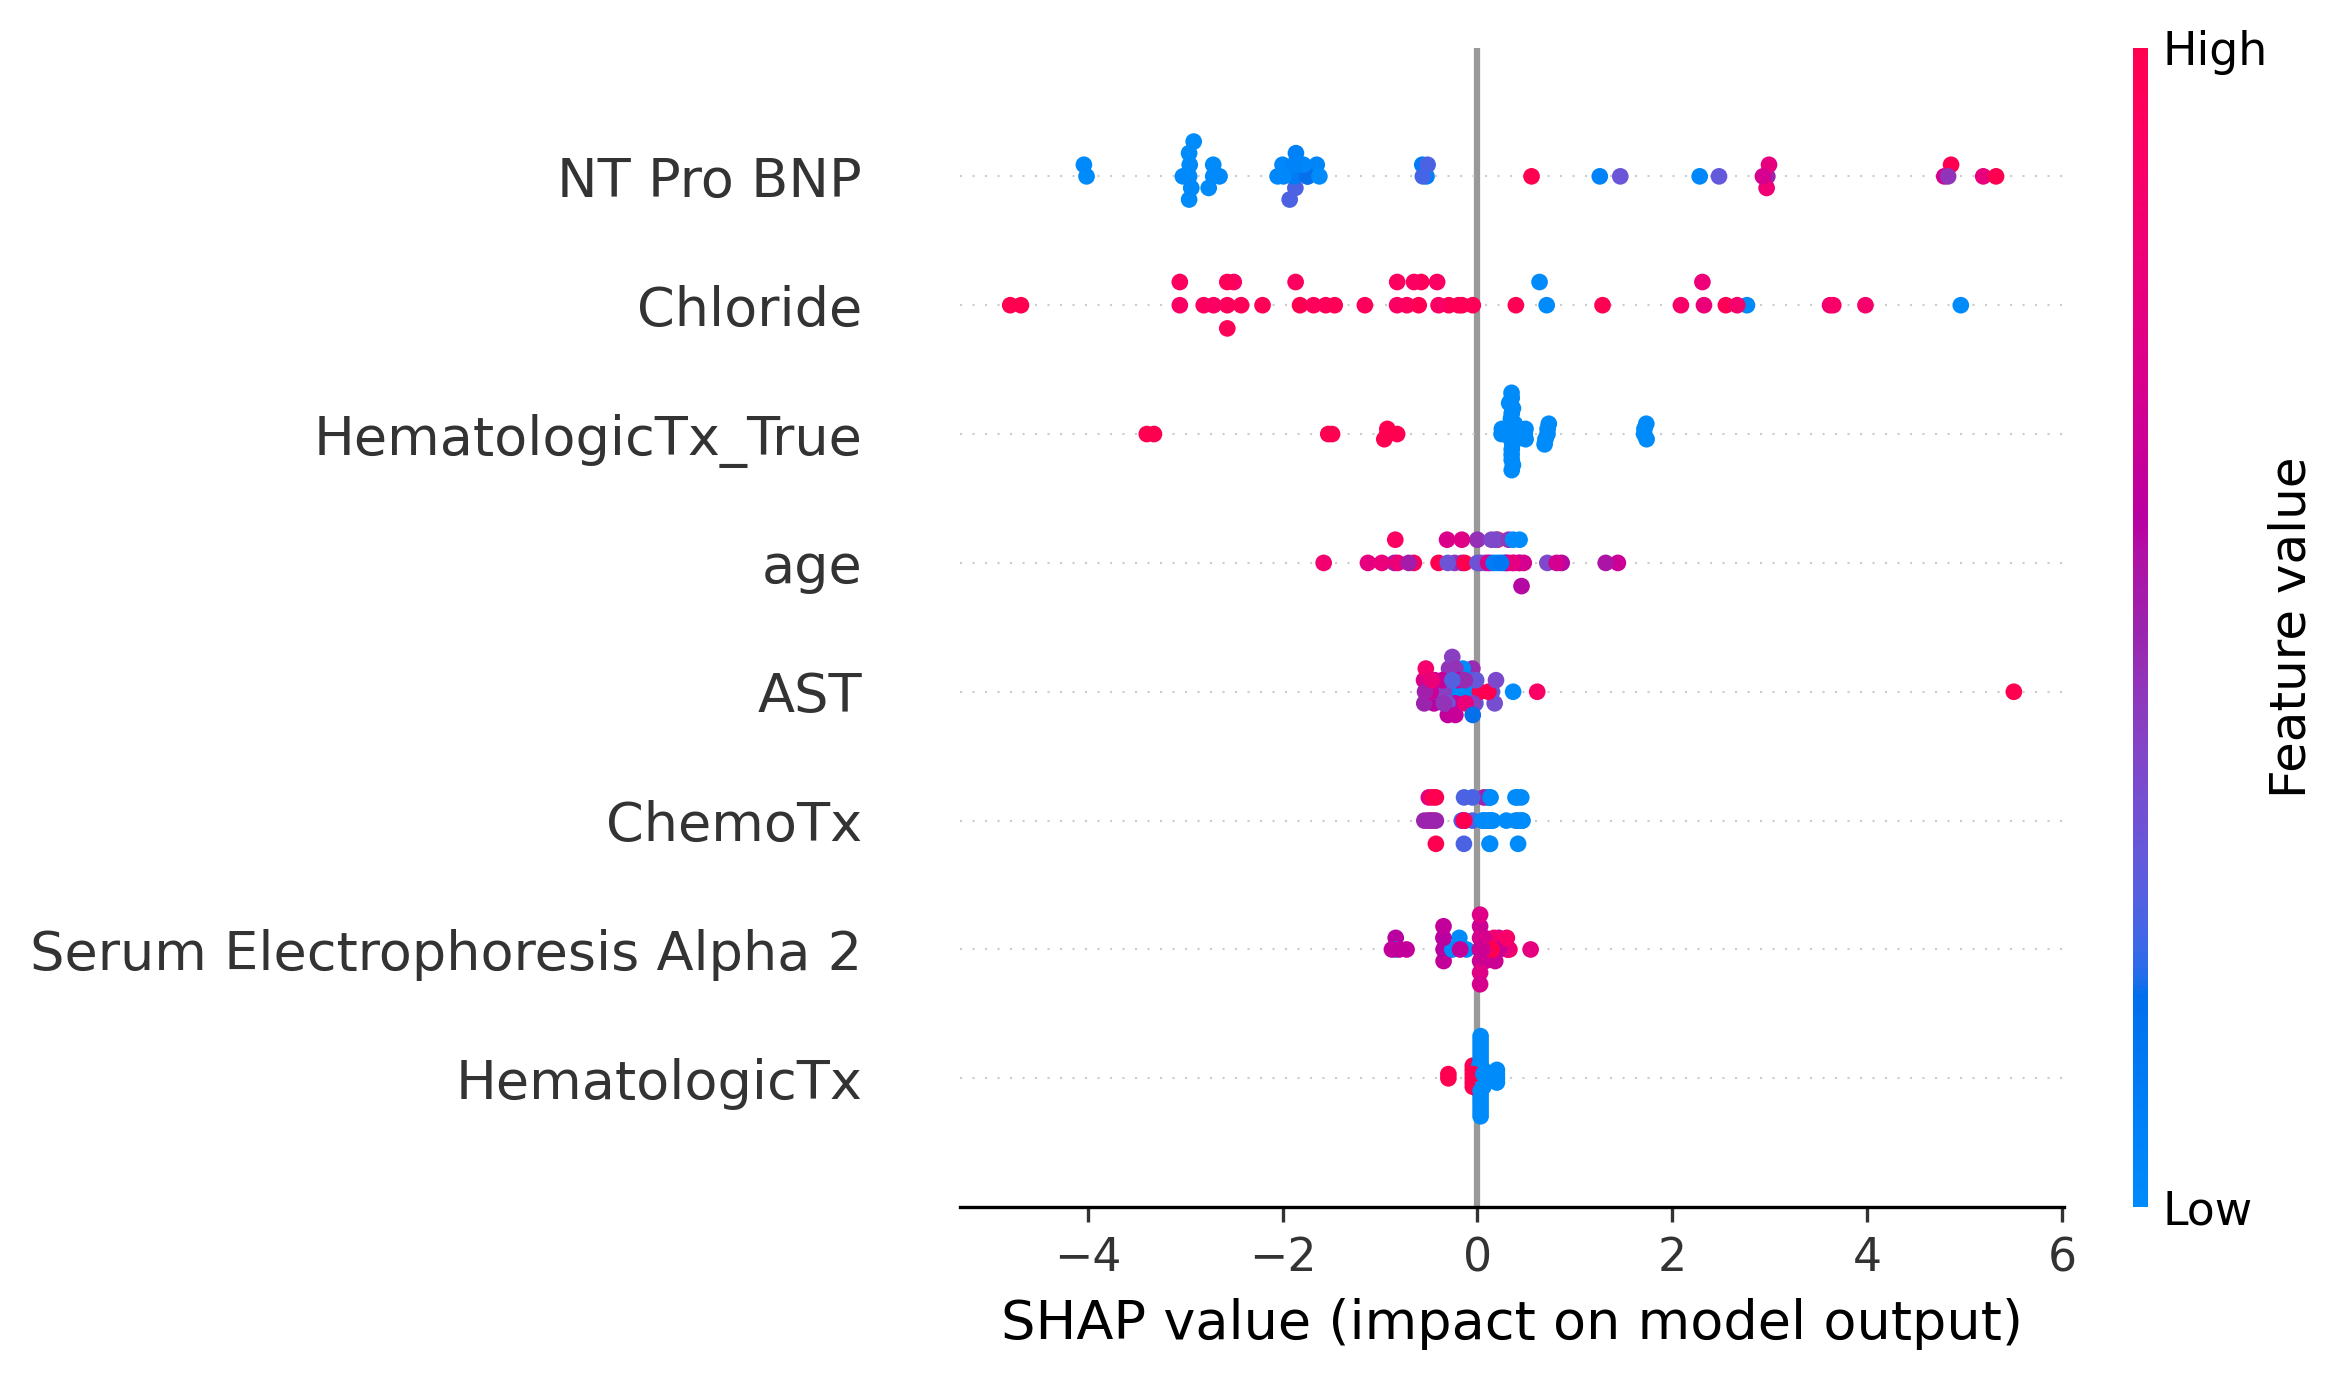

In [58]:
#borrowed from online source
#shap explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all_trim)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all_trim)

shap.summary_plot(shap_values, X_all_trim, feature_names = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)

# Show the plot
plt.show()

# exporting selected features to dataframe

In [59]:
selected_features = list(X.columns[svm_set_ranks[selected_run].features]) #getting list of selected features
dataTablePositive = dataTable[dataTable[y_column_Classification] == 1] #filtering for positive patients
dataTablePositive.index = dataTablePositive['DeID'] #setting index to patient id
dataTableNegative = dataTable[dataTable[y_column_Classification] == 0] #filtering for negative patients
dataTableNegative.index = dataTableNegative['DeID'] #setting index to patient id
df_selectedfeatures_allpts = dataTable[selected_features]
df_selectedfeatures_allpts.index = dataTable['DeID'] #adding the patient identifiers back to the dataframe


#saving this output to a sheet
outputToExcel(df_data = df_selectedfeatures_allpts[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = dataTablePositive[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "positive")
outputToExcel(df_data = dataTableNegative[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "negative")


# correlation and heat maps for the best performing features of the SVM model

In [60]:
import seaborn as sns

In [61]:
dataTable

DeID  CA_status_yes  sex_female  dx_mgus  dx_mm  age  survival(mo)  \
DeID                                                                       
B-02  B-02              1           0        1      0   48      9.466667   
C-03  C-03              1           1        0      1   59     17.000000   
E-01  E-01              1           0        1      0   50     71.300000   
E-02  E-02              1           0        1      0   64     20.466667   
F-03  F-03              1           0        0      1   61     52.000000   
G-02  G-02              1           1        0      1   36     30.000000   
I-01  I-01              1           1        0      1   55     33.000000   
I-03  I-03              1           0        1      0   67     10.033333   
J-02  J-02              1           1        0      1   68     26.000000   
K-02  K-02              1           1        0      1   68     27.000000   
M-02  M-02              1           0        1      0   70     24.800000   
N-03  N-03              1           0        0      1   69      8.000000   
O-03  O-03              1           1        0      1   71      4.233333   
Q-02  Q-02              1           0        1      0   69     41.100000   
Q-03  Q-03              1           1        0      1   41      3.466667   
T-01  T-01              1           0        0      0   71     14.433333   
V-02  V-02              1           0        0      1   79     50.000000   
W-01  W-01              1           0        0      1   57     42.000000   
X-01  X-01              1           0        1      0   80      5.300000   
X-02  X-02              1           0        1      0   63     38.233333   
Y-02  Y-02              1           1        1      0   57     12.766667   
A-02  A-02              0           1        1      0   74      7.266667   
B-03  B-03              0           0        0      1   43     18.000000   
C-01  C-01              0           1        0      0   56     27.000000   
C-02  C-02              0           0        0      1   59     33.000000   
E-03  E-03              0           0        1      0   62     13.866667   
F-01  F-01              0           0        0      1   55    147.000000   
G-03  G-03              0           1        1      0   69     11.533333   
H-01  H-01              0           0        1      0   56     47.066667   
H-02  H-02              0           0        0      1   65     26.000000   
M-01  M-01              0           0        0      1   47     83.000000   
N-01  N-01              0           0        0      0   79     15.000000   
N-02  N-02              0           0        0      1   76     10.000000   
P-01  P-01              0           0        0      1   77     53.000000   
P-02  P-02              0           1        0      1   64     26.000000   
Q-01  Q-01              0           1        1      0   57     48.800000   
R-01  R-01              0           0        0      1   68     21.000000   
R-03  R-03              0           1        1      0   62     12.966667   
S-02  S-02              0           1        0      1   69     20.000000   
T-02  T-02              0           0        0      1   60     19.000000   
V-01  V-01              0           1        0      1   66     43.000000   
W-02  W-02              0           0        1      0   72     13.500000   
Y-01  Y-01              0           0        0      1   59     40.000000   
Z-01  Z-01              0           1        0      0   72      2.000000   

      ChemoTx  HematologicTx  RadiationTx  ...  Serum Electrophoresis Alpha 1  \
DeID                                       ...                                  
B-02        0              0            0  ...                            0.4   
C-03        2              0            0  ...                            0.5   
E-01        0              0            0  ...                           -1.0   
E-02        0              0            0  ...                            0.3   
F-03        4          

In [62]:
# create correlation matrix for all the input features
feature_correlation = dataTable.drop(columns= 'DeID').corr(method='spearman')
selected_features = list(X.columns[svm_set_ranks[selected_run].features])

#for CA positive
feature_correlation_CApositive = dataTable[dataTable[y_column_Classification] == 1].drop(columns = "DeID").corr(method='spearman')

#for CA negative
feature_correlation_CAnegative = dataTable[dataTable[y_column_Classification] == 0].drop(columns = "DeID").corr(method='spearman')

In [63]:
outputToExcel(df_data = feature_correlation, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = feature_correlation_CApositive, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCApos")
outputToExcel(df_data = feature_correlation_CAnegative, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCAneg")

In [64]:
colormap = "RdBu"

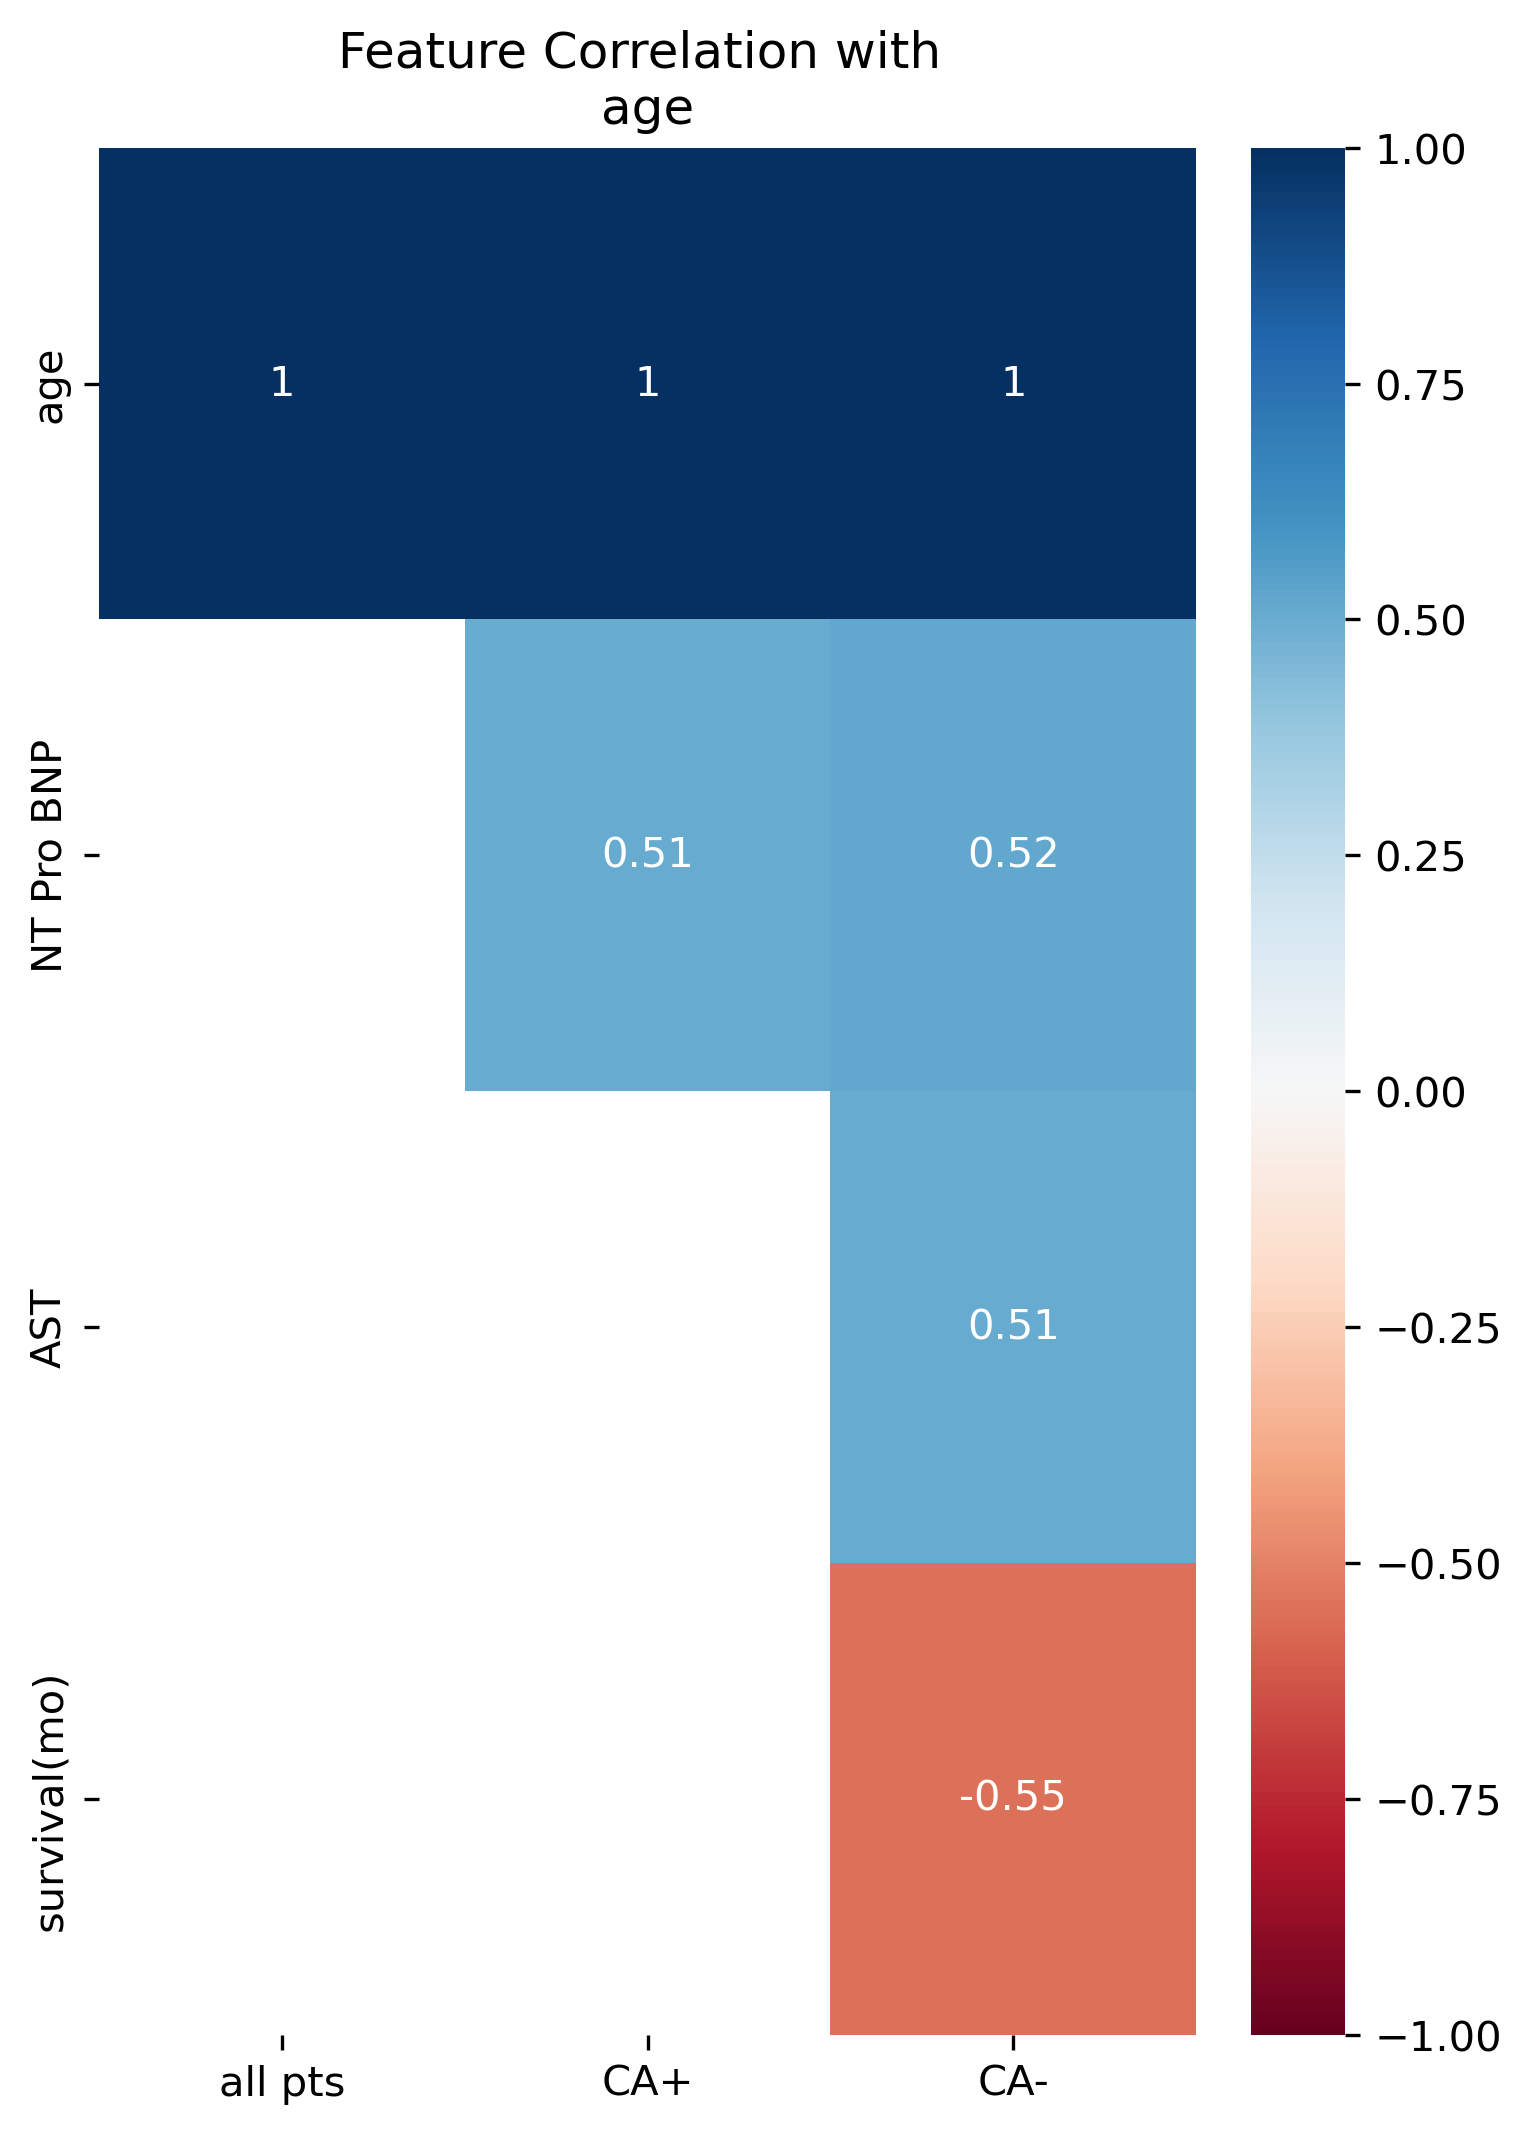

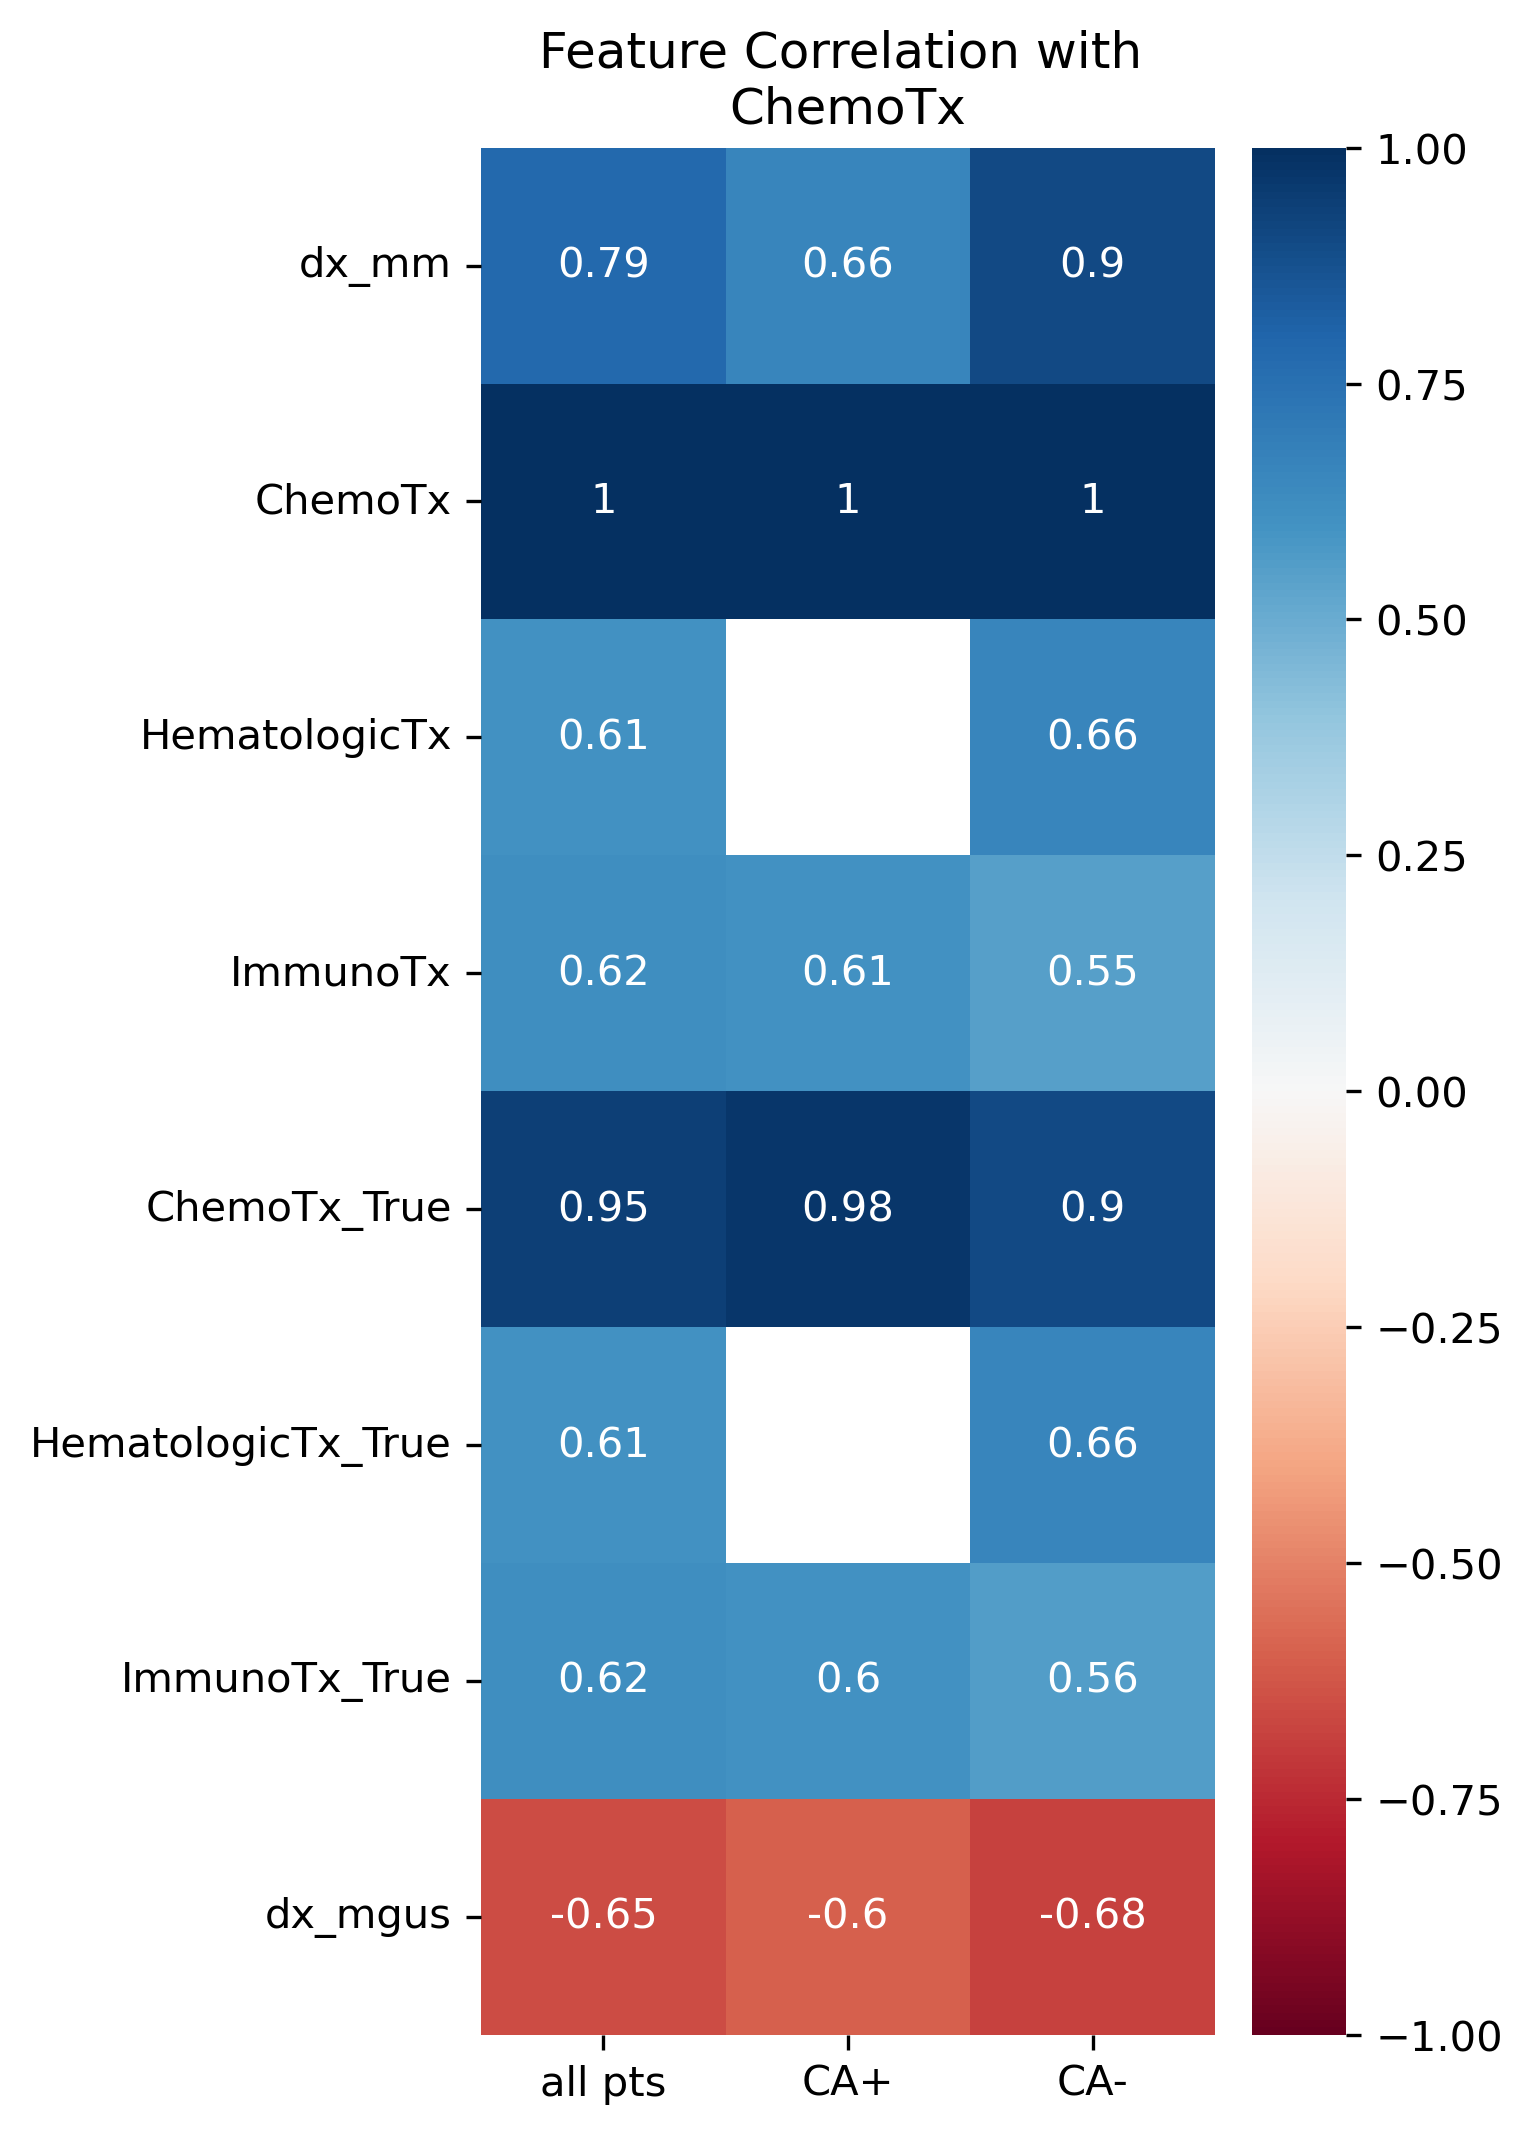

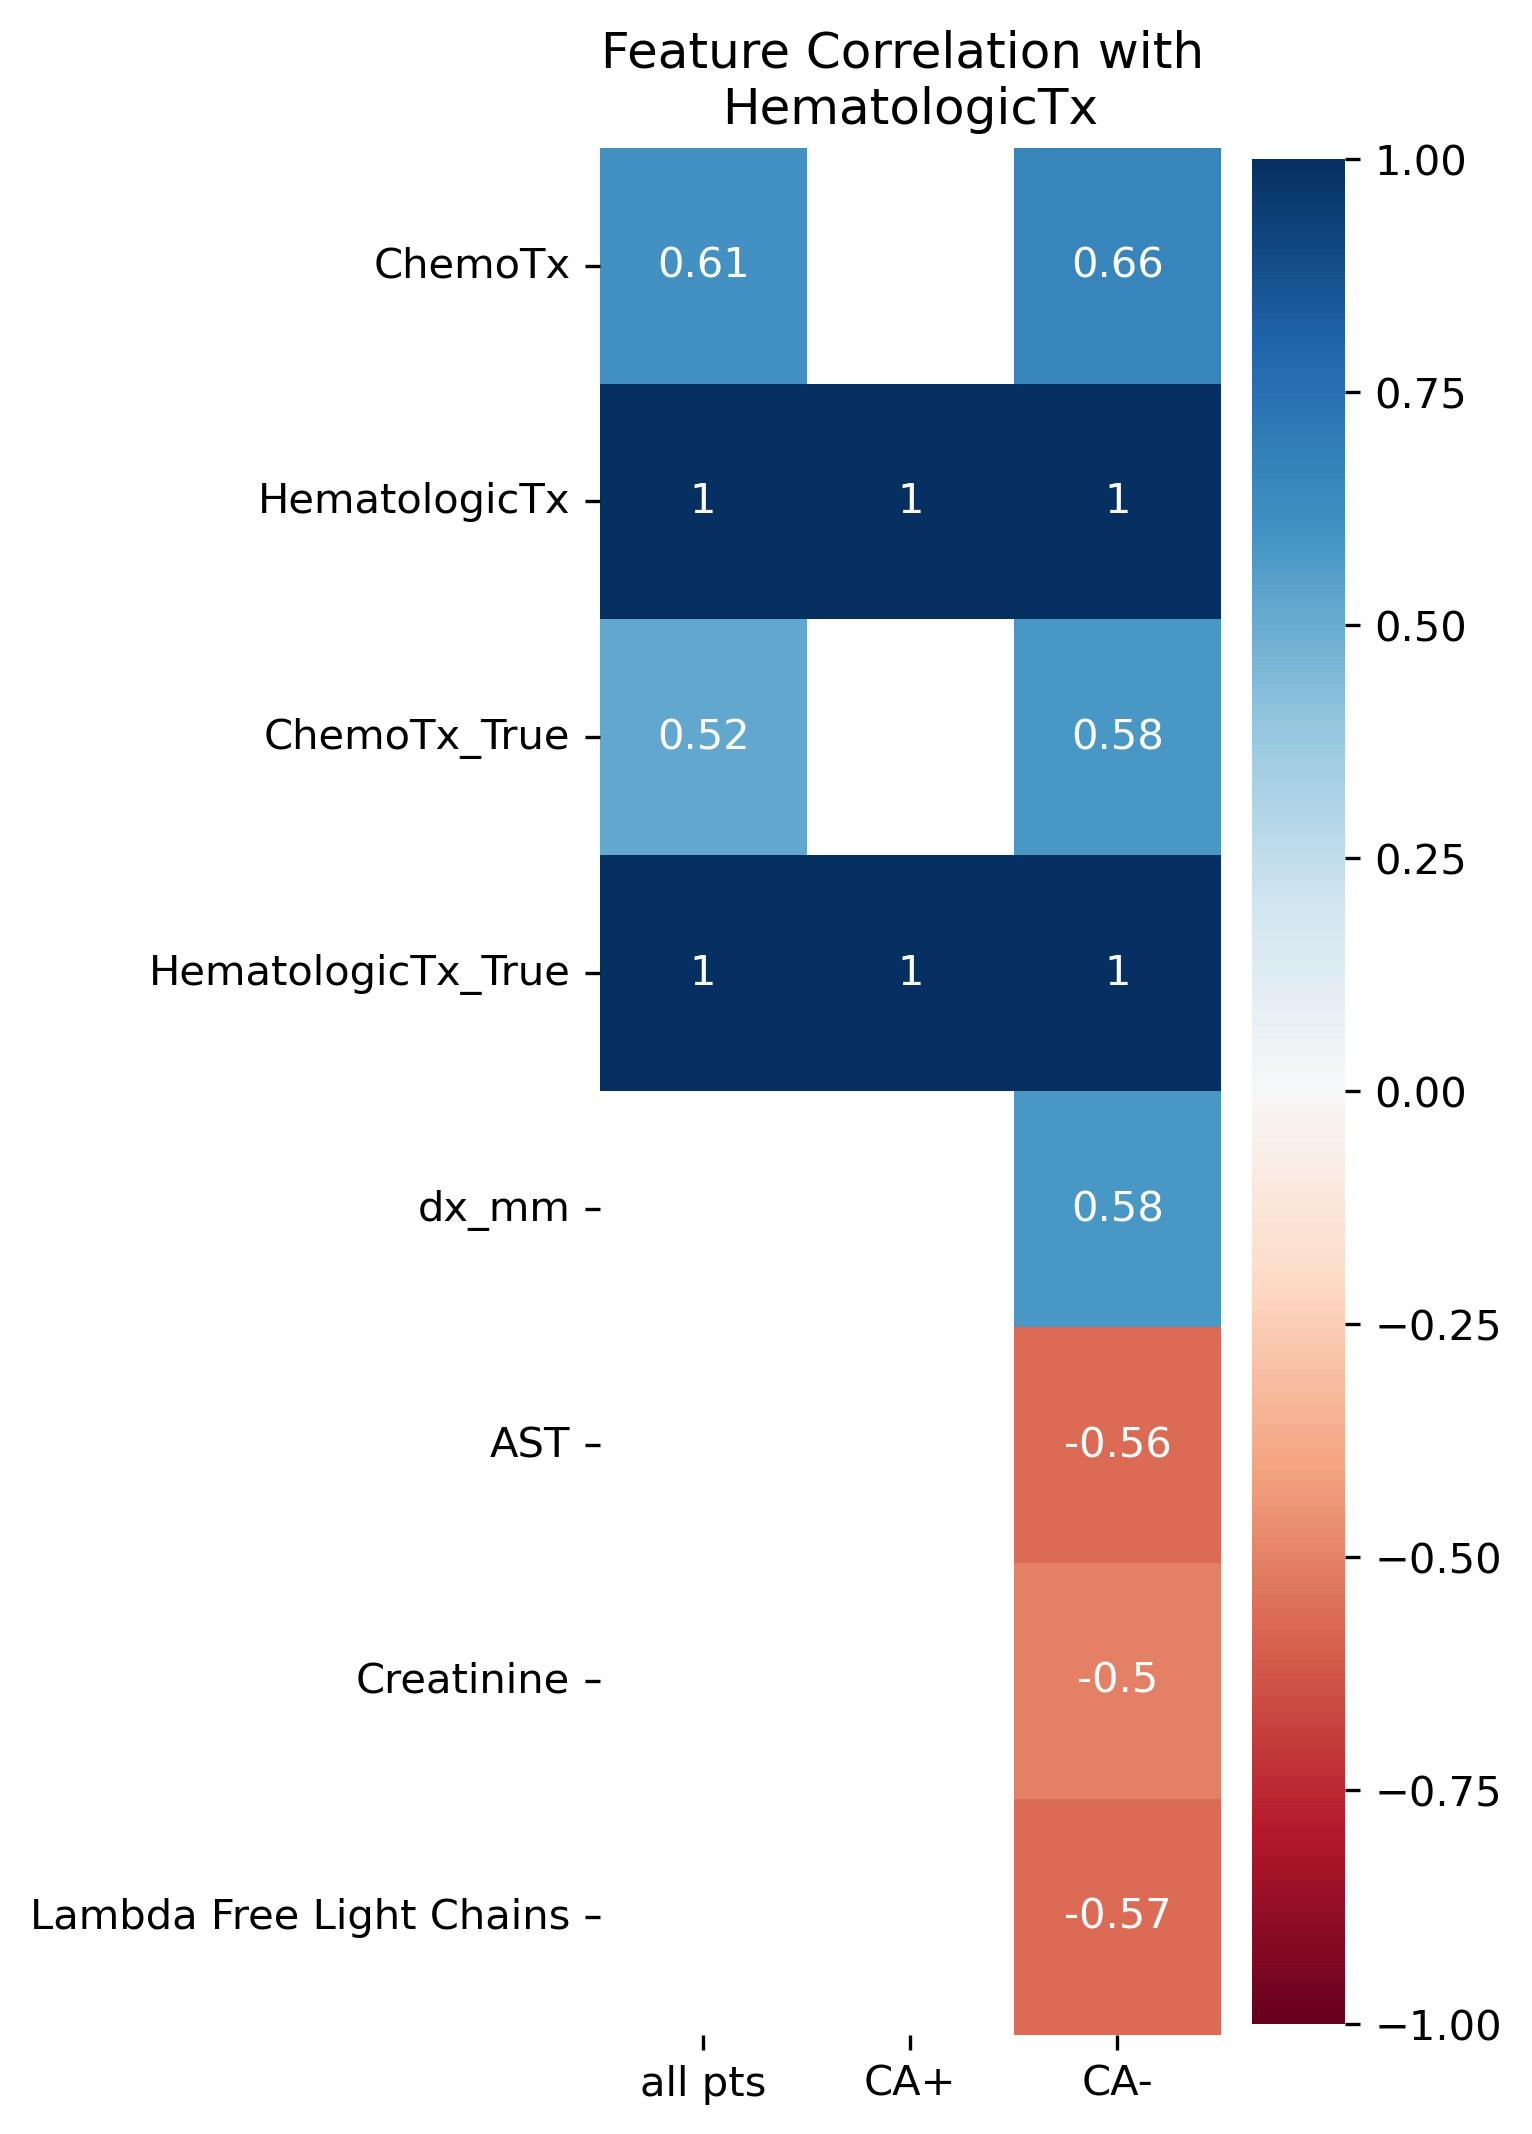

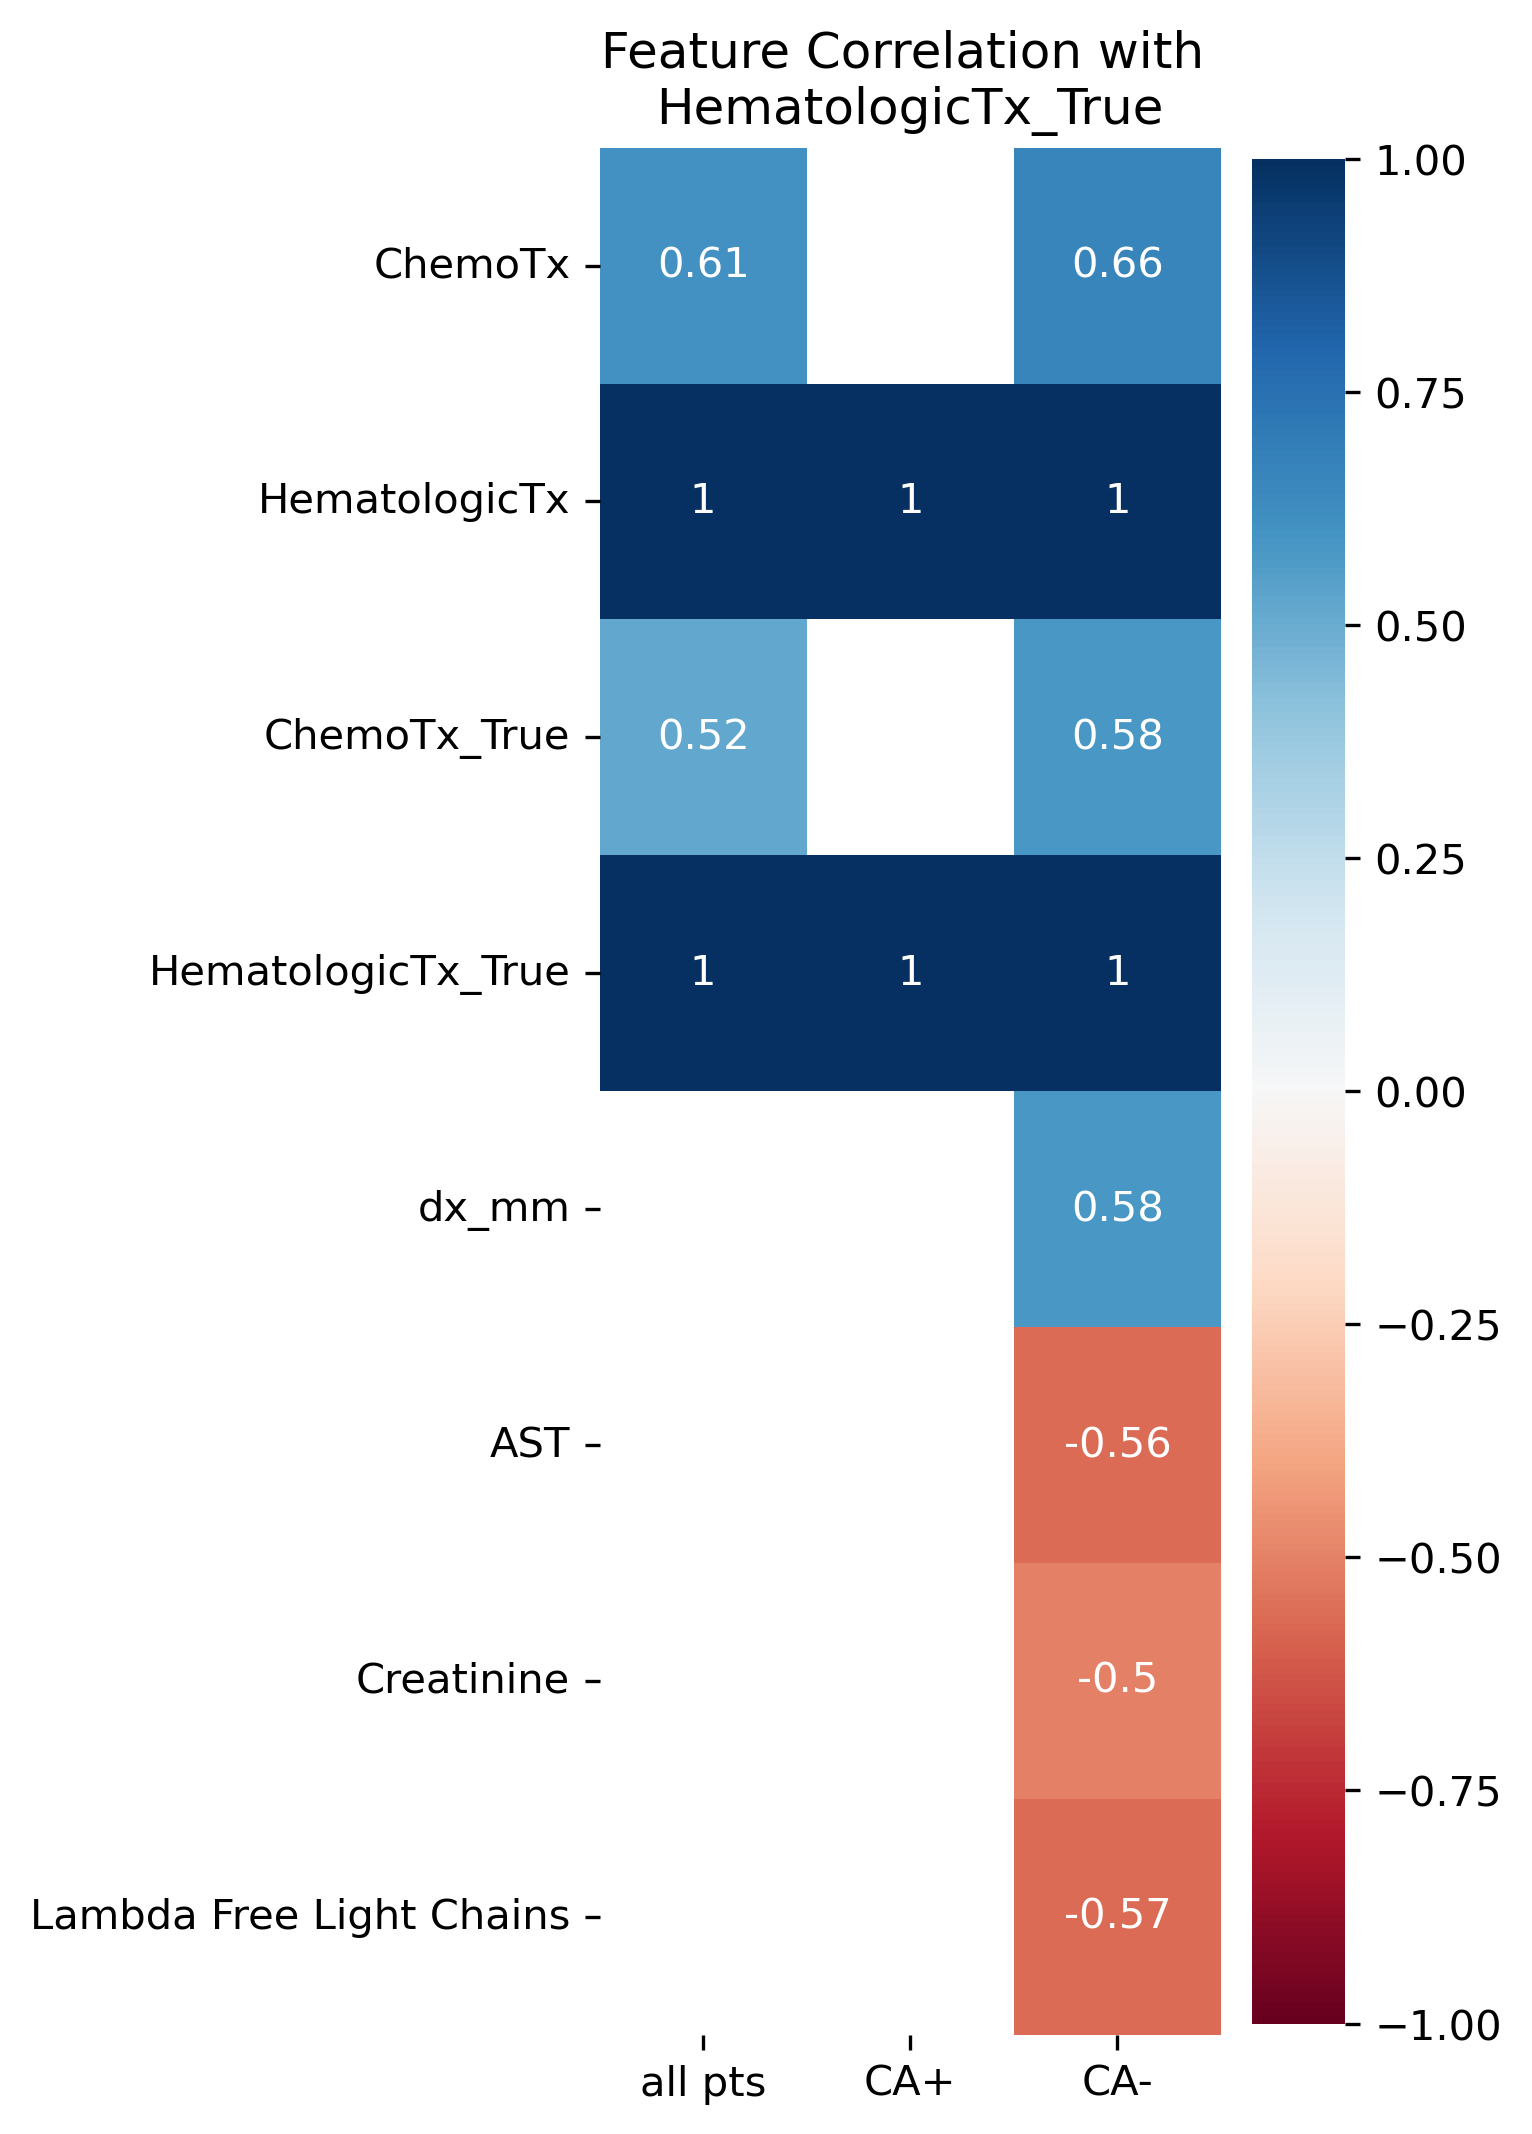

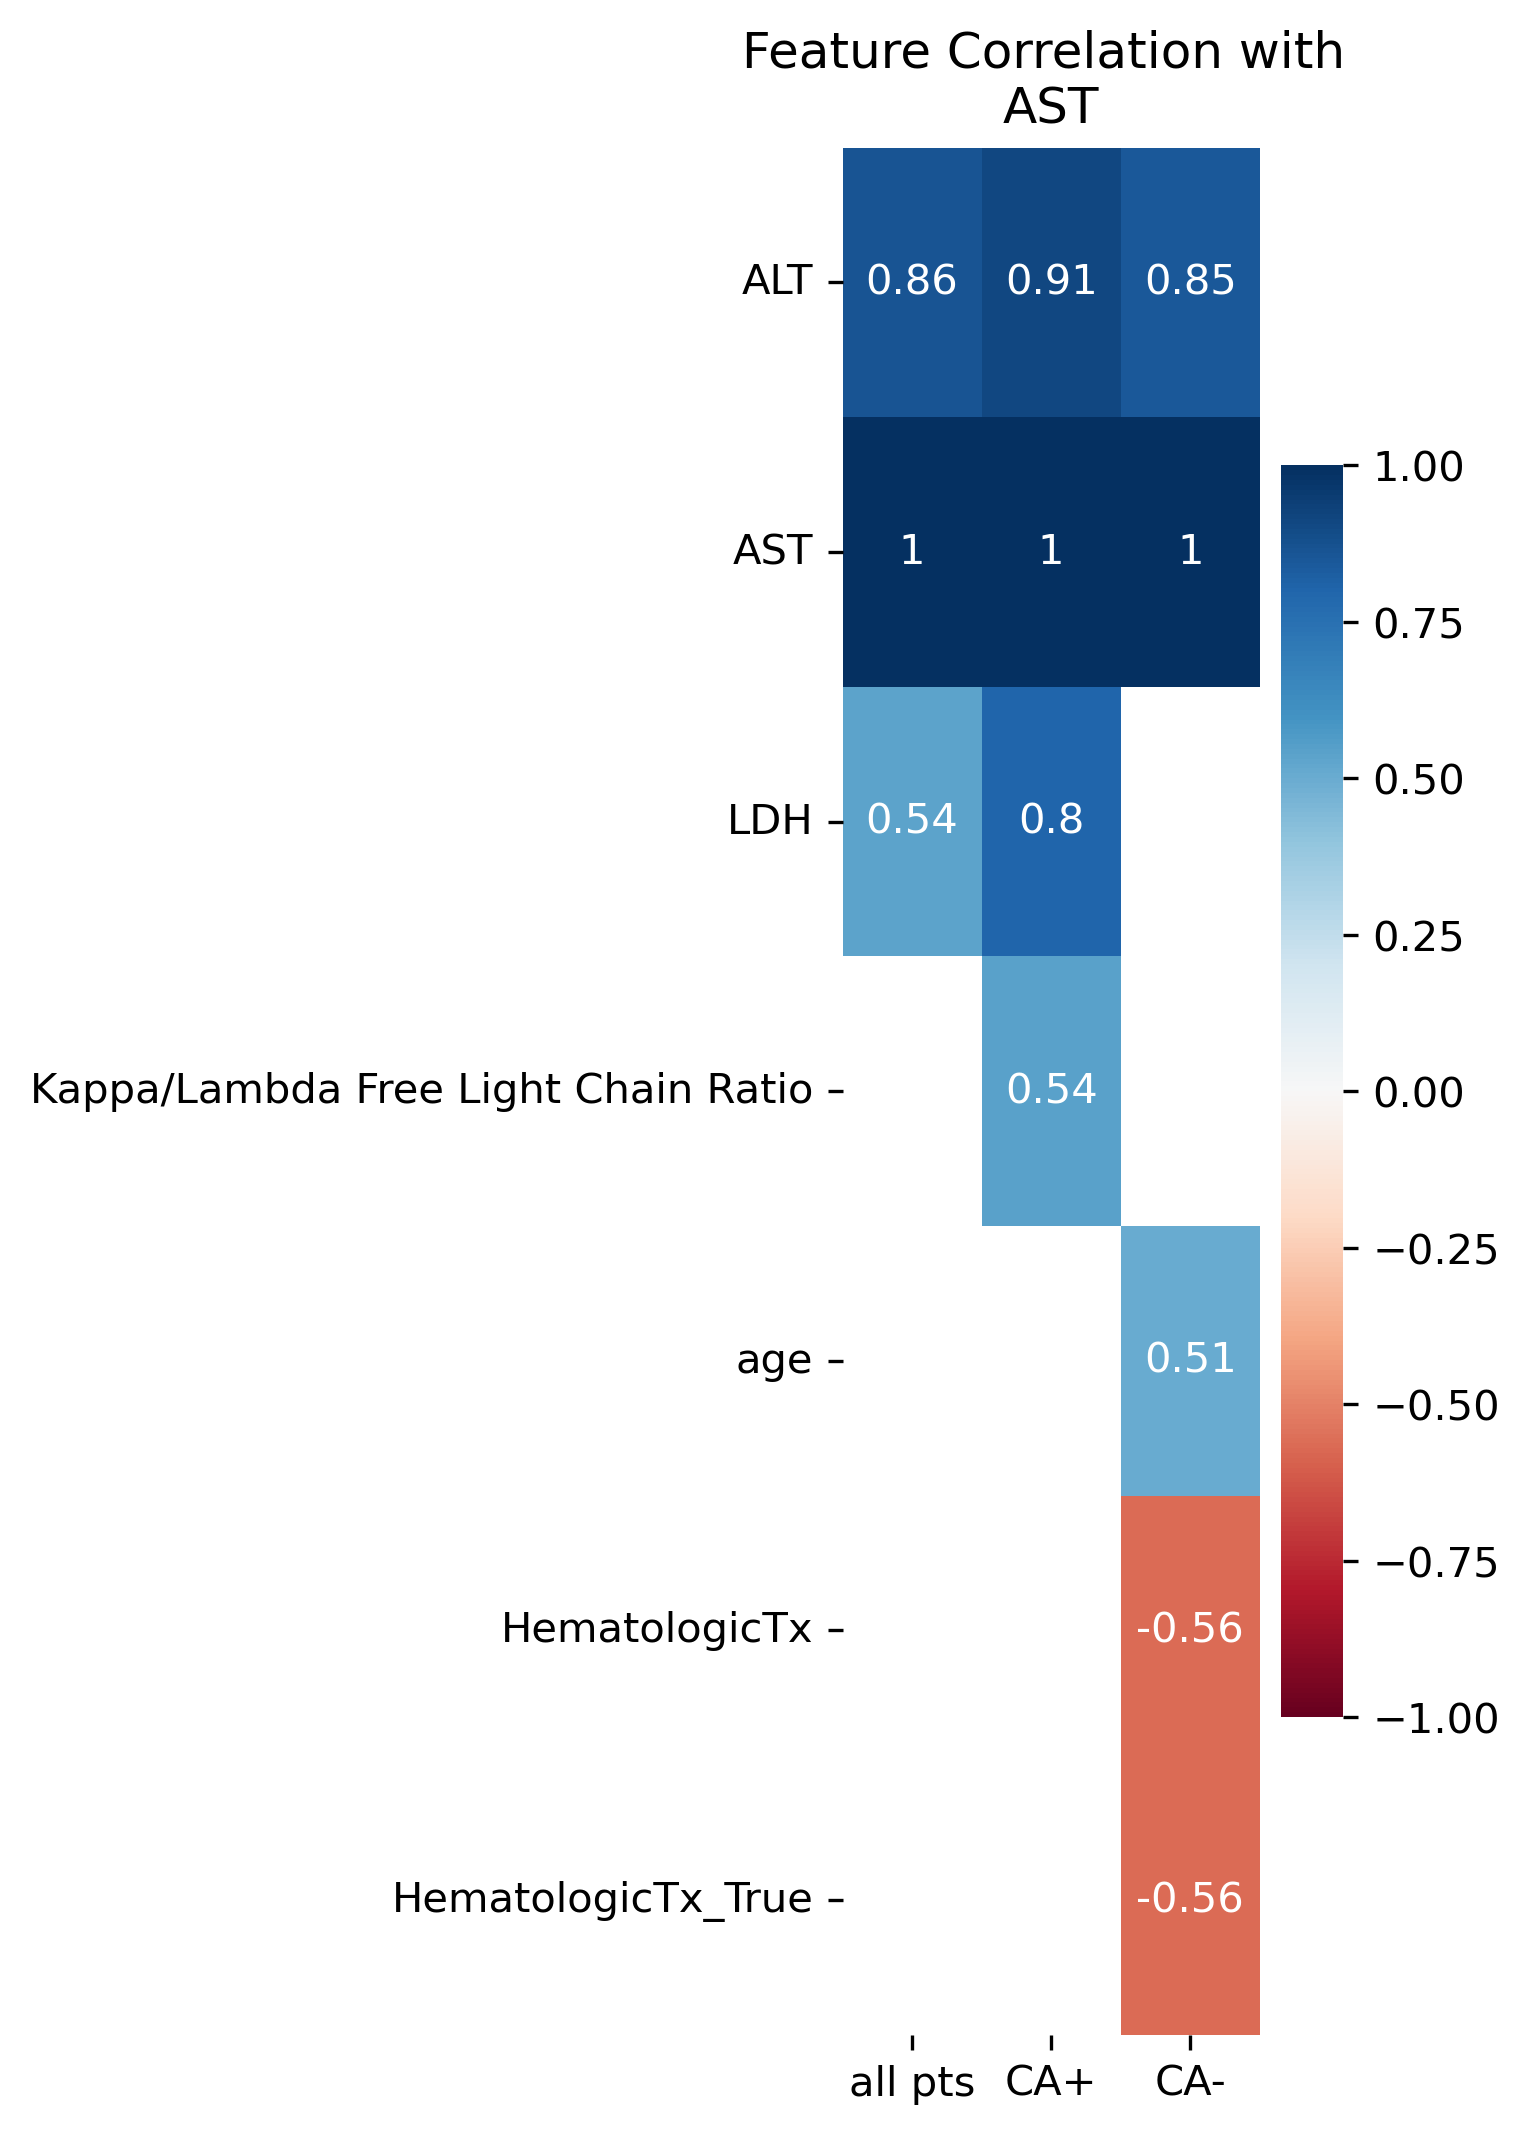

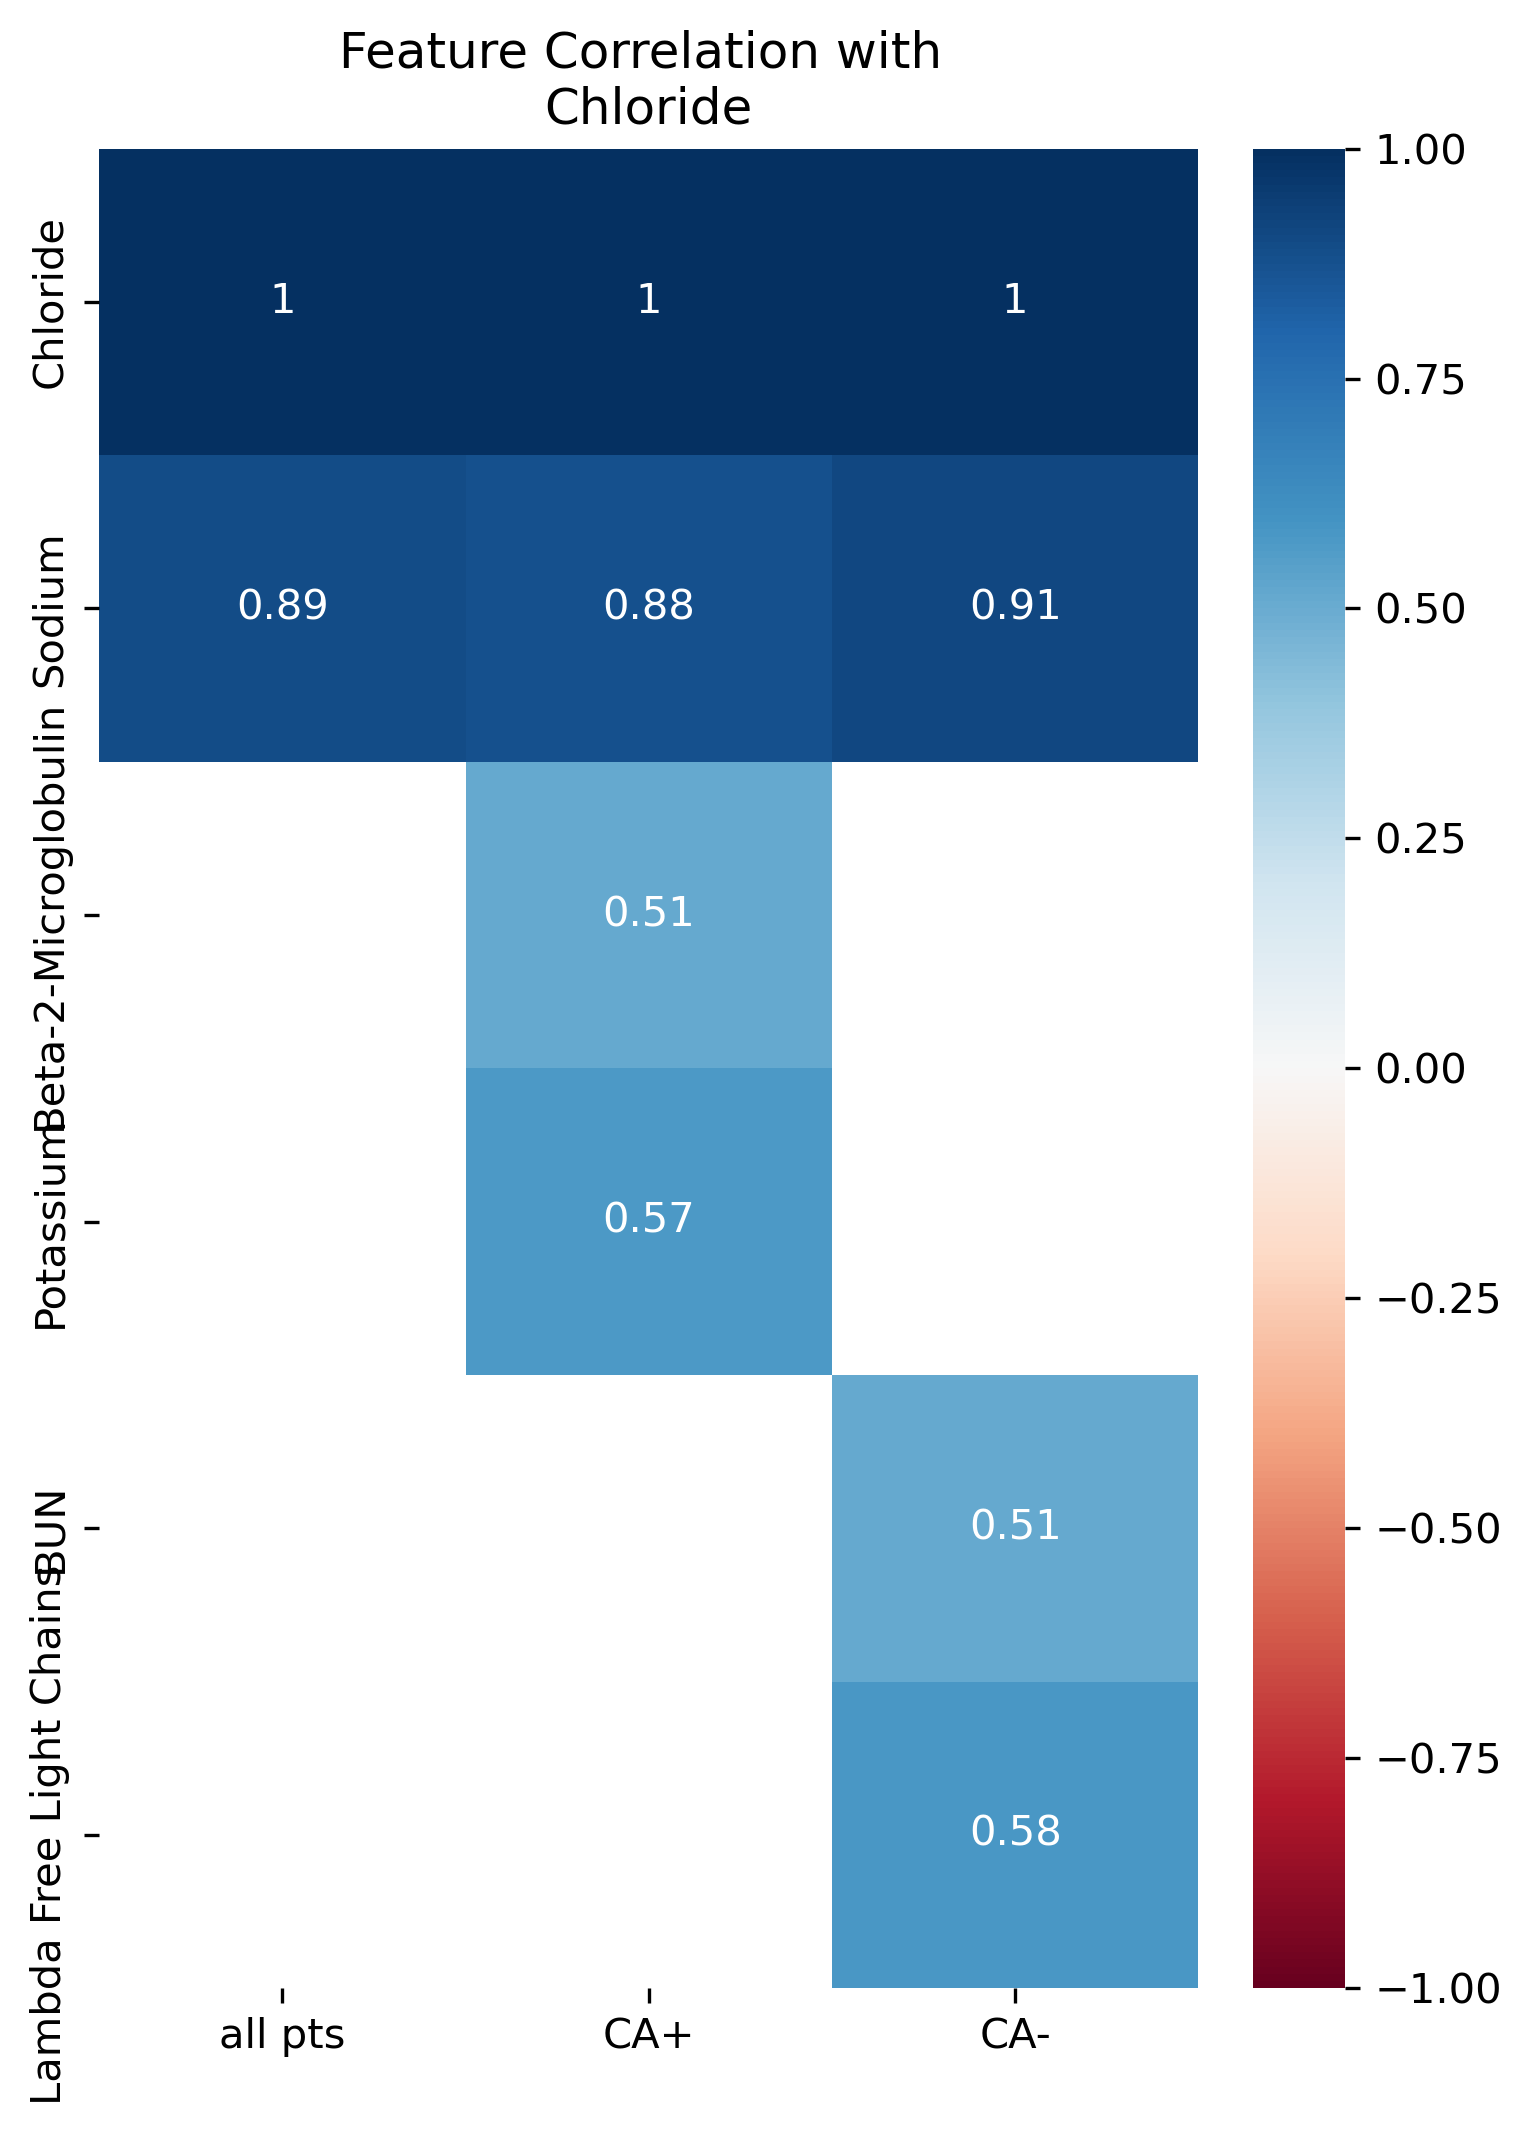

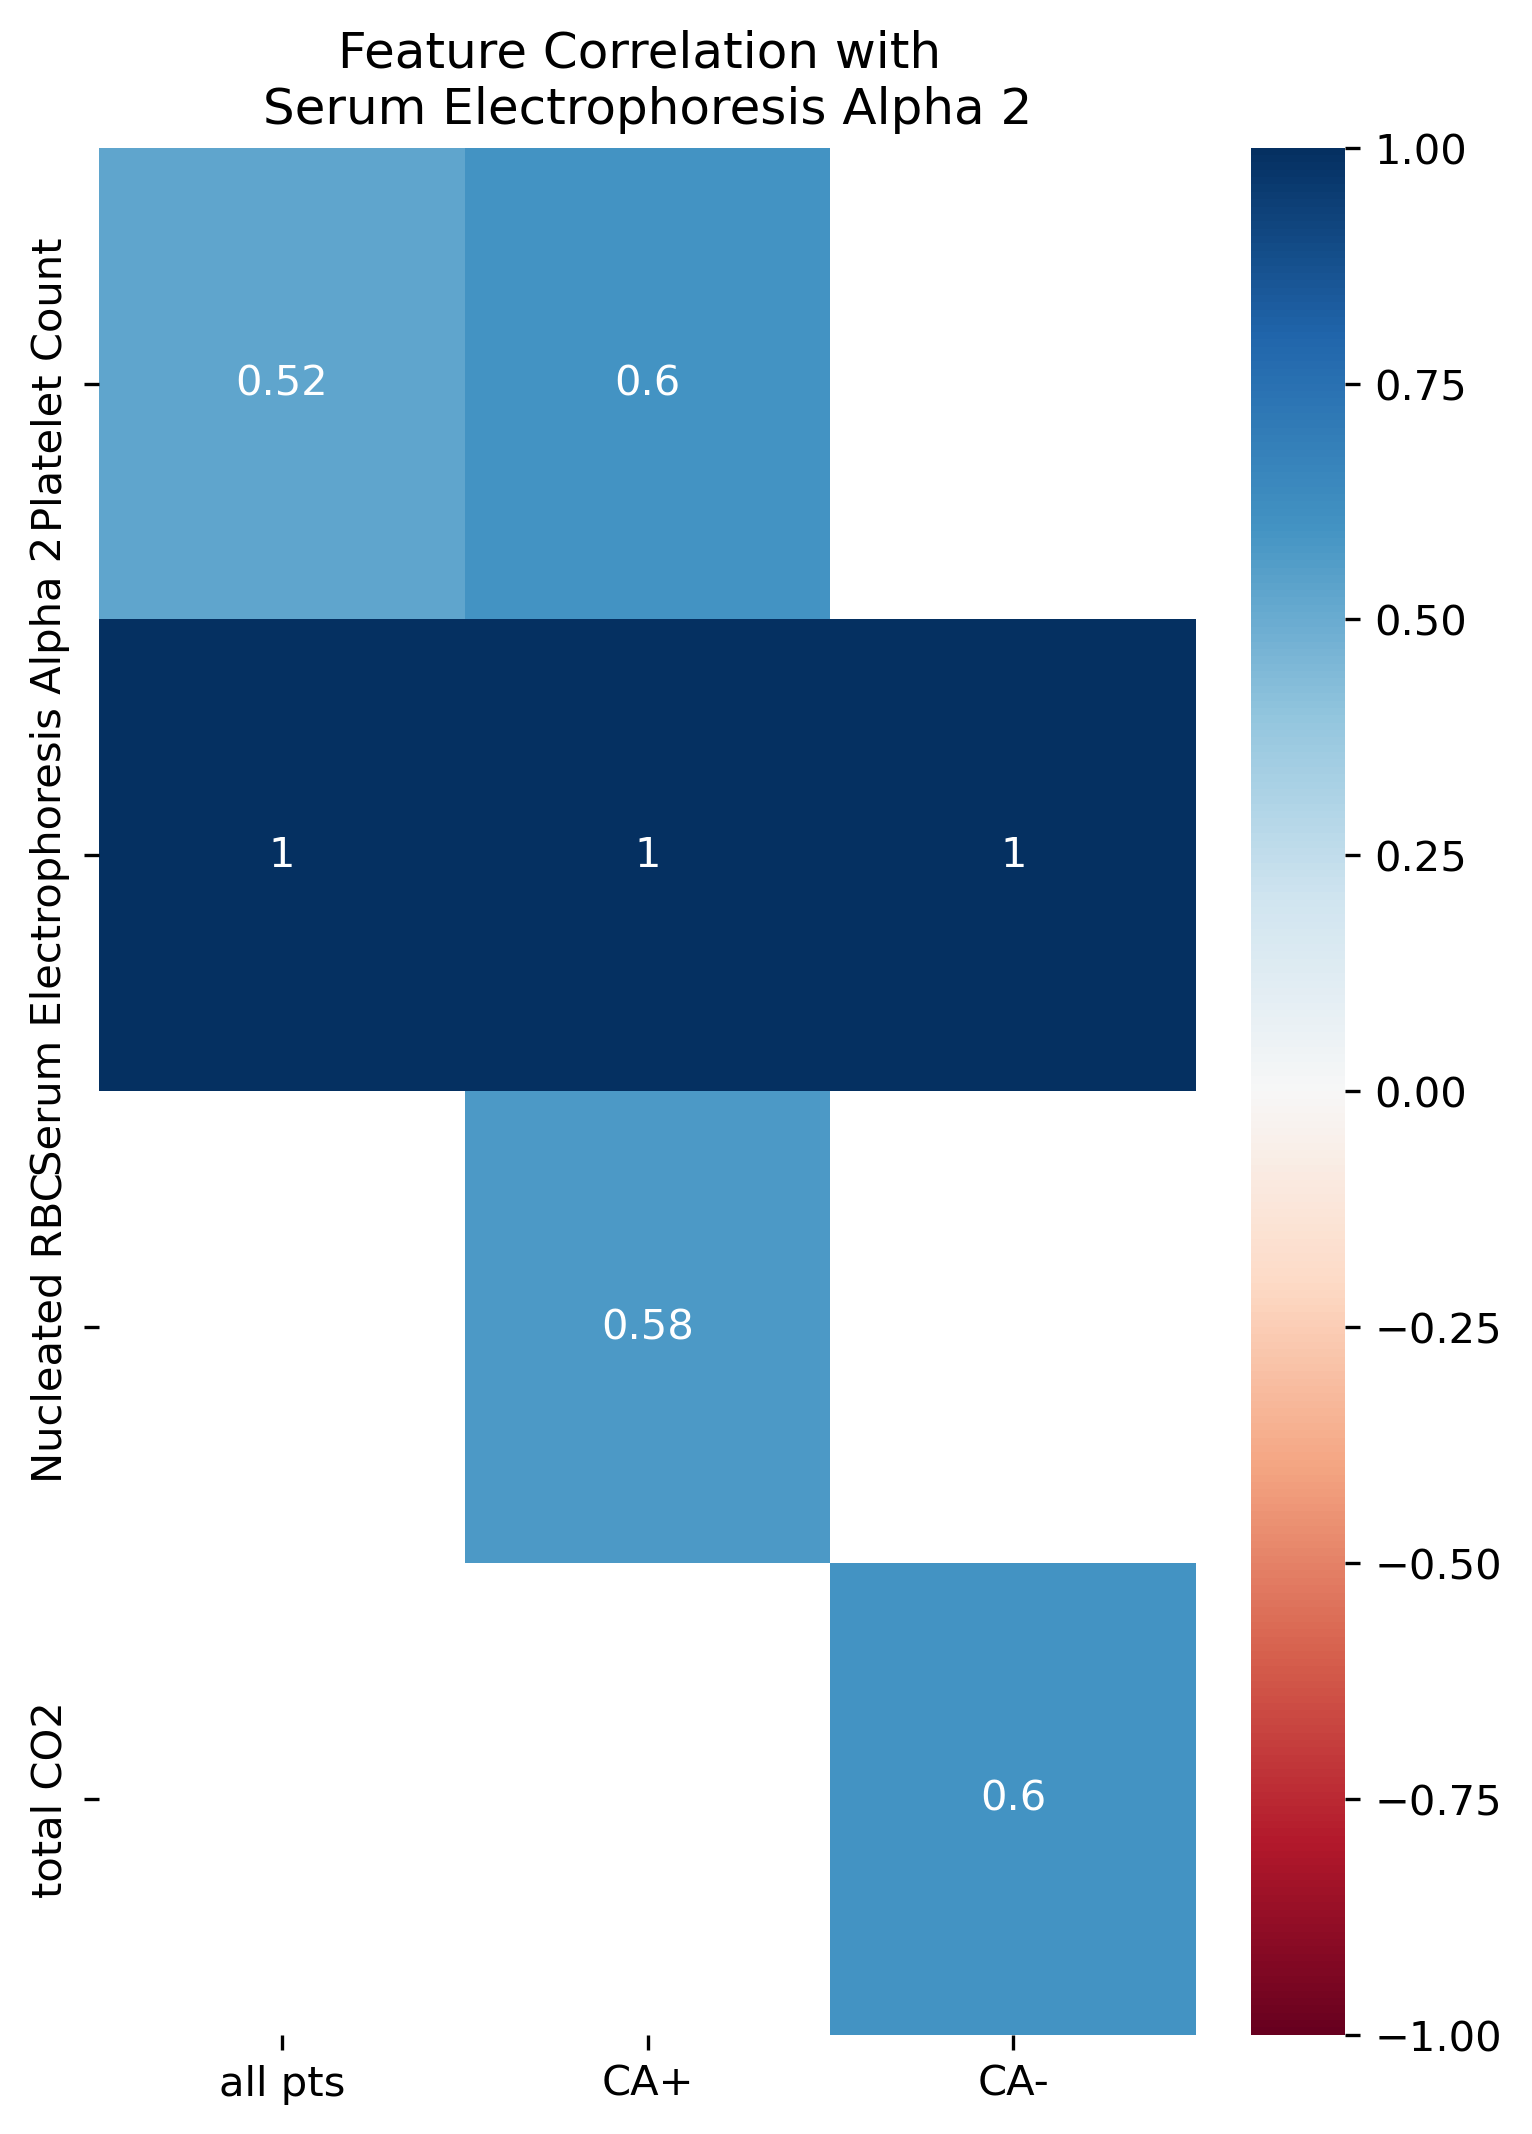

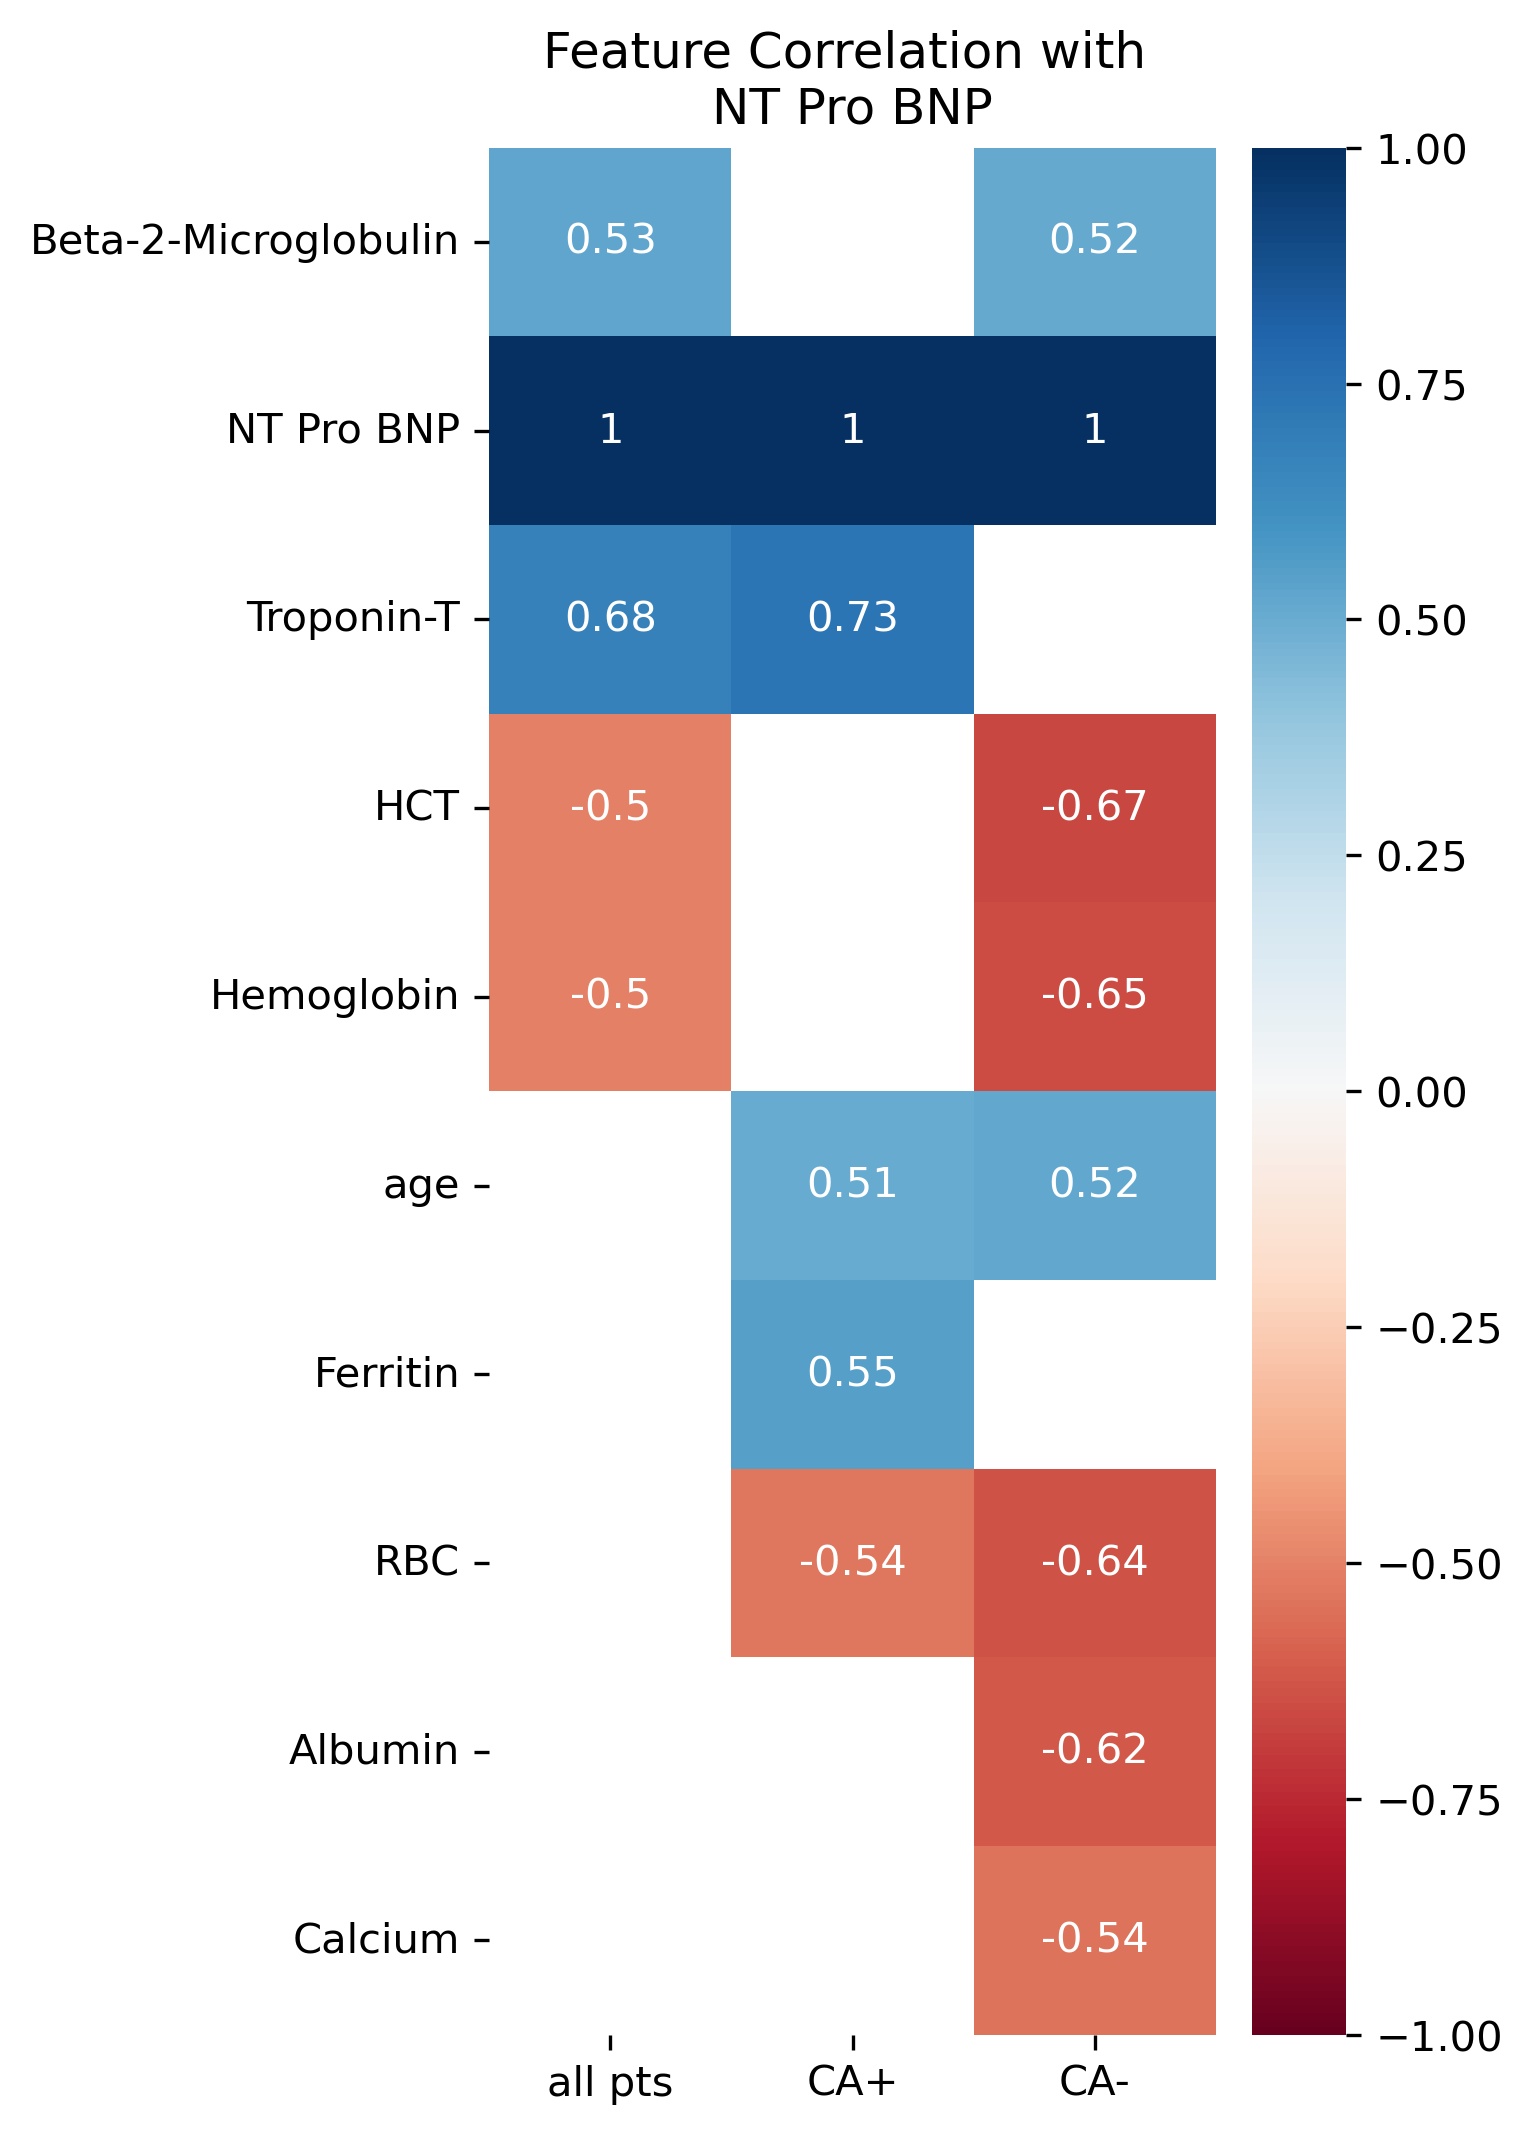

In [65]:
for feature_name in selected_features:
    feat_corr_sig_allpts = pd.concat([feature_correlation[feature_correlation[feature_name]>=0.5][feature_name], 
                                    feature_correlation[feature_correlation[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CApos = pd.concat([feature_correlation_CApositive[feature_correlation_CApositive[feature_name]>=0.5][feature_name], 
                                     feature_correlation_CApositive[feature_correlation_CApositive[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CAneg = pd.concat([feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]>=0.5][feature_name],
                                     feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_concat = pd.concat([feat_corr_sig_allpts,feat_corr_sig_CApos,feat_corr_sig_CAneg], axis = 1)
    feat_corr_sig_concat.columns = ['all pts', 'CA+', 'CA-']

    outputToExcel(df_data = feat_corr_sig_concat, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix ,
                       parent_dir= saving_dirrectory, folderName=makingFolder, sheetName=feature_name.replace("%", "").replace("/",""))

    fig, ax = plt.subplots(figsize = (5,7),layout = 'constrained')
    sns.heatmap(feat_corr_sig_concat, cmap= colormap, vmin= -1, vmax = 1, center = 0, annot = True, ax = ax)
    ax.set_title("Feature Correlation with \n"+ str(feature_name))

    figCommon =feature_name.replace("%", "").replace("/","") + "_heatmap_"
    # fig_file_out = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                         fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)
    # fig.savefig(fig_file_out, bbox_inches = 'tight')
    # fig_file_out_jpg = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                 fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out, fileExtension= '.jpg')
    # fig.savefig(fig_file_out_jpg, bbox_inches = 'tight')